# Insurance Data EDA & Classification
This project focuses on exploratory data analysis (EDA) and classification of an insurance dataset. 

The goal is to predict whether customers will respond positively to a vehicle insurance policy offer. 

Through this project, we will explore the data, clean and preprocess it, and build machine learning models to classify customer responses.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s4e7/sample_submission.csv
/kaggle/input/playground-series-s4e7/train.csv
/kaggle/input/playground-series-s4e7/test.csv


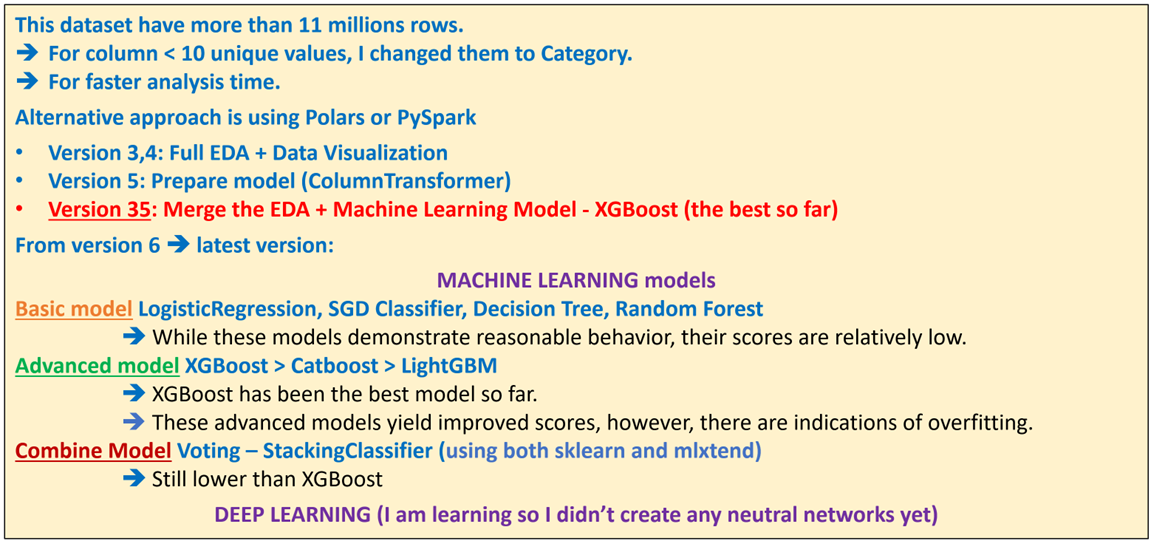

# Loading the Data and Initial Exploration
In this step, we load the insurance dataset and conduct an initial exploration. The dataset includes various customer features, such as demographic information, vehicle details, and their interaction history with the company.

The objective is to understand the general structure of the data, identify missing values, and explore some key features for further analysis.

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s4e7/train.csv',index_col = "id", engine="pyarrow")
test = pd.read_csv('/kaggle/input/playground-series-s4e7/test.csv',index_col = "id", engine="pyarrow")
print('Size of train dataset: {} ____ Size of test dataset: {}'.format(train.shape,test.shape))
train.head()

Size of train dataset: (11504798, 11) ____ Size of test dataset: (7669866, 10)


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


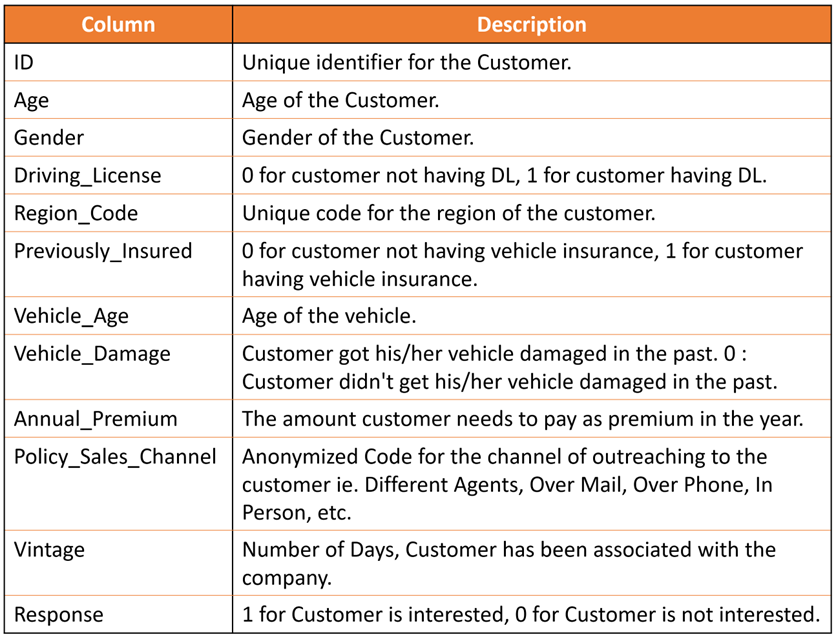

# Dataset Summary and Categorical Feature Transformation

This section provides an overview of the dataset using `train.describe().T` to display key statistics for numerical columns, helping us identify any potential issues like outliers or missing values.

## Categorical Feature Identification and Transformation:
1. **Identifying Categorical Columns**: Columns with fewer than 10 unique values are identified as categorical since they represent distinct categories rather than continuous data.
2. **Converting to Categorical Type**: These columns are converted to the `category` type to optimize memory and improve model performance.
3. **Reordering 'Vehicle_Age'**: The 'Vehicle_Age' column is reordered to reflect its natural progression (`< 1 Year`, `1-2 Year`, `> 2 Years`), ensuring proper handling as an ordinal variable during model training.

These transformations prepare the dataset for machine learning, ensuring that categorical data is handled appropriately.

In [3]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,11504798.0,38.383563,14.993459,20.0,24.0,36.0,49.0,85.0
Driving_License,11504798.0,0.998022,0.044431,0.0,1.0,1.0,1.0,1.0
Region_Code,11504798.0,26.418690,12.991590,0.0,15.0,28.0,35.0,52.0
Previously_Insured,11504798.0,0.462997,0.498629,0.0,0.0,0.0,1.0,1.0
Annual_Premium,11504798.0,30461.370411,16454.745205,2630.0,25277.0,31824.0,39451.0,540165.0
Policy_Sales_Channel,11504798.0,112.425442,54.035708,1.0,29.0,151.0,152.0,163.0
Vintage,11504798.0,163.897744,79.979531,10.0,99.0,166.0,232.0,299.0
Response,11504798.0,0.122997,0.328434,0.0,0.0,0.0,0.0,1.0


In [4]:
from pandas.api.types import CategoricalDtype

test['Response'] = 0
# Identify columns with fewer than 10 unique values
less = [col for col in train.columns if train[col].nunique() < 10]

print('Columns with LESS than 10 unique values:', less)
print('Columns with MORE than 10 unique values:', [col for col in train.columns if col not in less])

# Convert identified columns to categorical type
for col in less:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')

# Define the new order of categories for 'Vehicle_Age'
new_categories = ['< 1 Year', '1-2 Year', '> 2 Years']
new_dtype = CategoricalDtype(categories=new_categories, ordered=True)

# Update the 'Vehicle_Age' column with the new dtype in both train and test DataFrames
train['Vehicle_Age'] = train['Vehicle_Age'].astype(new_dtype)
test['Vehicle_Age'] = test['Vehicle_Age'].astype(new_dtype)

Columns with LESS than 10 unique values: ['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Response']
Columns with MORE than 10 unique values: ['Age', 'Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']


# EDA: Data Visualization

In this section, we visualize the distribution of key categorical columns and analyze how they relate to the target variable (`Response`).

We use count plots to display the distribution of each categorical variable, with an additional plot that includes the `Response` as a hue to highlight differences between customers who responded positively and negatively. Percentages are added to the bars for better interpretability.

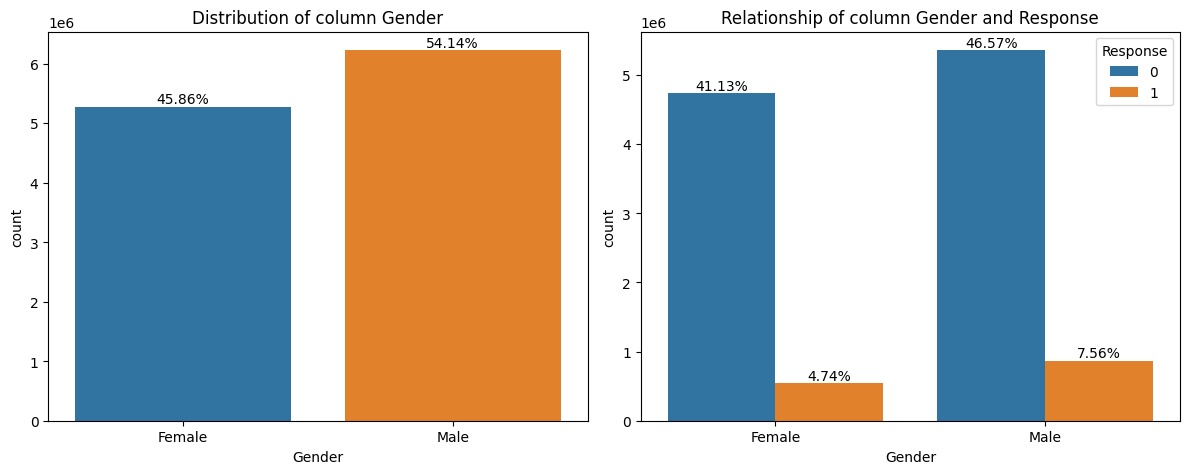

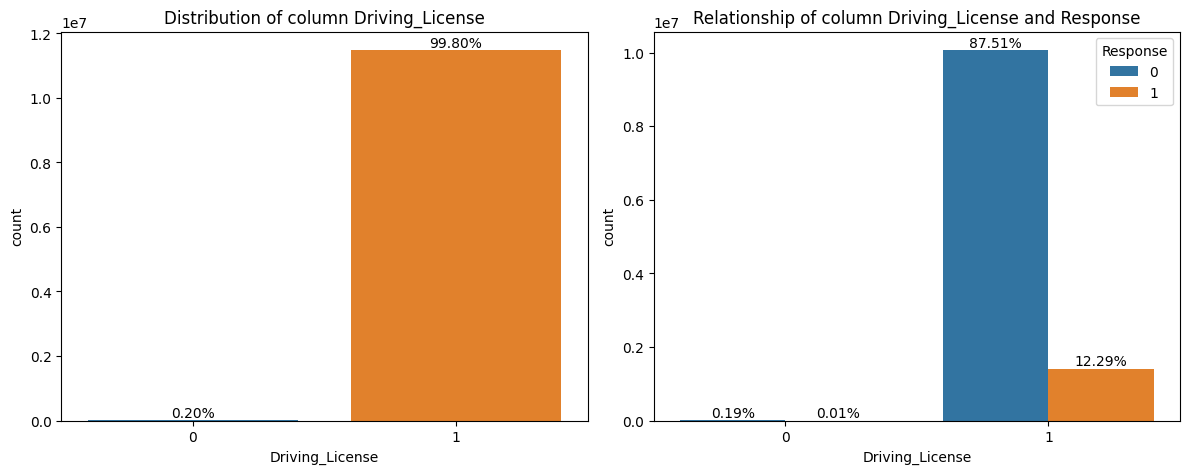

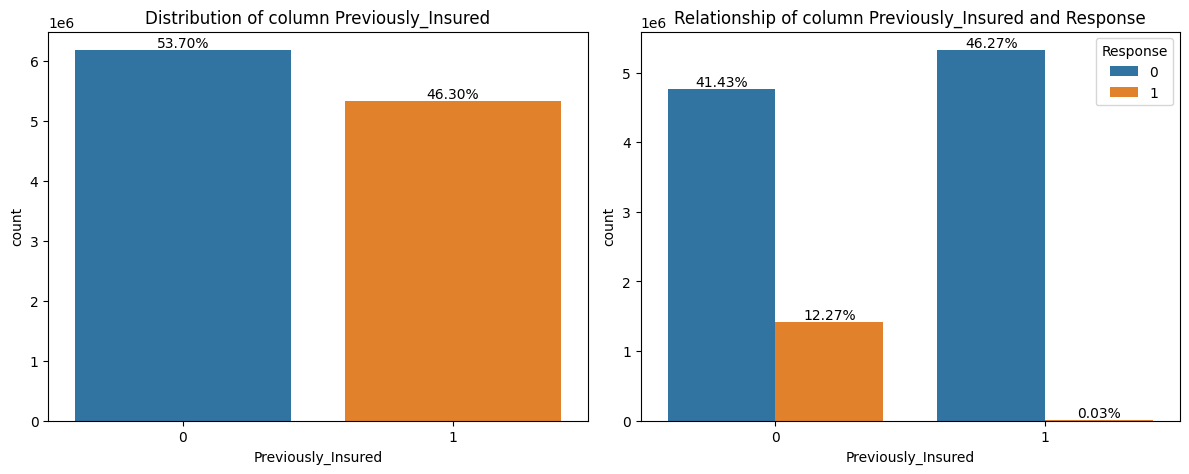

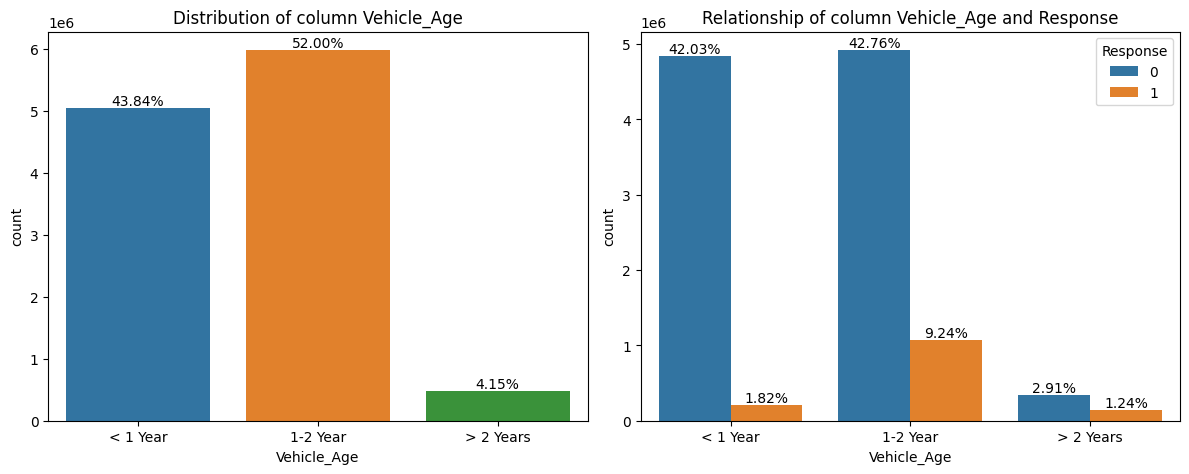

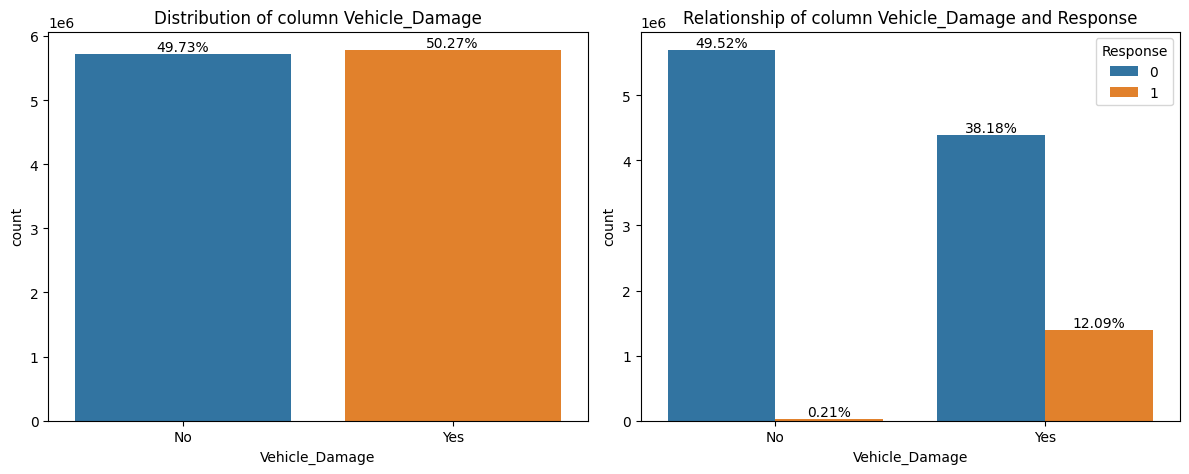

In [5]:
for i in less[:-1]:
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plotting the first countplot
    sns.countplot(x=i, data=train, ax=ax[0])
    ax[0].set_title(f'Distribution of column {i}')
    
    # Adding percentages on top of the bars for the first countplot
    total = len(train)
    for p in ax[0].patches:
        percentage = f'{100 * p.get_height() / total:.2f}%'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height() + 30 
        ax[0].annotate(percentage, (x, y), ha='center', va='bottom')

    # Plotting the second countplot with hue='Response'
    sns.countplot(x=i, data=train, hue='Response', ax=ax[1])
    ax[1].set_title(f'Relationship of column {i} and Response')
    
    # Adding percentages on top of the bars for the second countplot
    for p in ax[1].patches:
        height = p.get_height()
        total = sum([p.get_height() for p in ax[1].patches if p.get_x() == p.get_x()])  # Total height for this x value
        percentage = f'{100 * height / total:.2f}%' if total > 0 else '0%'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height() + 30
        ax[1].annotate(percentage, (x, y), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

## Key Insights:
- **Driver's License**: Although most individuals possess a driver's license, the majority are not interested in the insurance offer.
- **Previously Insured**: The dataset is fairly balanced between customers who previously had vehicle insurance and those who did not, but only 13% of previously uninsured individuals show interest in responding.
- **Vehicle Age**: Customers with newer vehicles (<1 year) are less likely to respond compared to those with older vehicles (>2 years).
- **Vehicle Damage**: Customers who reported vehicle damage have a similar response rate as those with prior insurance, indicating a potential correlation between past incidents and interest in vehicle insurance.

# Correlation Analysis

In this section, we use Spearman's correlation to explore the relationships between key features. Spearman's method is chosen as it captures both linear and non-linear monotonic relationships. We focus on highly correlated pairs (|correlation| ≥ 0.5) for further insights.

,Feature 1,Feature 2,Correlation
11,Vehicle_Age,Age,0.830604
33,Policy_Sales_Channel,Vehicle_Age,-0.619321
29,Policy_Sales_Channel,Age,-0.656080
19,Vehicle_Damage,Previously_Insured,-0.836214


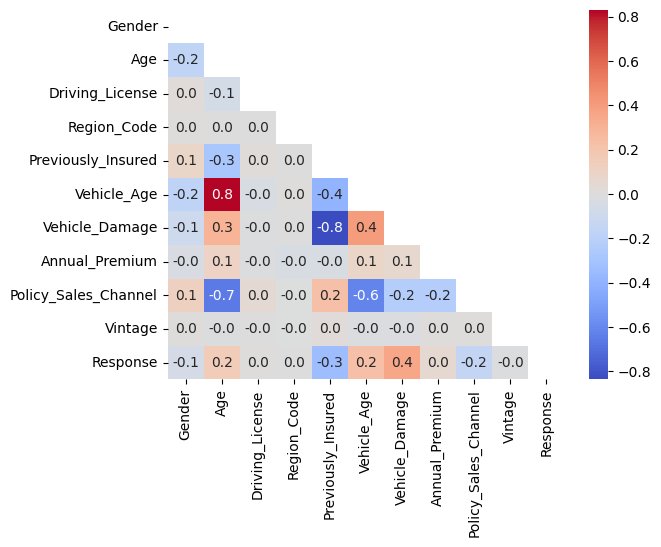

In [6]:
new = train.copy()
new['Gender'] = new['Gender'].map({'Male':0,'Female':1})
new['Vehicle_Age'] = new['Vehicle_Age'].map({'< 1 Year':0, '1-2 Year':1,'> 2 Years':2})
new['Vehicle_Damage'] = new['Vehicle_Damage'].map({'Yes':1,'No':0})

sns.heatmap(new.corr(method='spearman'),
           mask = np.triu(np.ones_like(new.corr(method='spearman'),dtype=bool)),
           annot=True,cmap='coolwarm',fmt='.1f')

high_pairs = new.corr(method='spearman').where(np.tril(np.ones(new.corr(method='spearman').shape), k=-1).astype(bool))
high_pairs = high_pairs.stack().reset_index()
high_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
high_pairs = high_pairs[(high_pairs['Correlation'] >= 0.5) | (high_pairs['Correlation'] <= -0.5)]

high = high_pairs.sort_values('Correlation',ascending=False)
high

## Key Correlations:
- **Previously_Insured & Vehicle_Damage (-0.8362)**: Customers with prior insurance are less likely to have experienced vehicle damage, possibly due to more cautious driving or having insurance post-incident.
- **Age & Vehicle_Age (-0.537)**: Younger customers tend to have newer vehicles, while older customers are more likely to own older vehicles.
- **Age & Policy_Sales_Channel (-0.59)**: Older customers prefer traditional channels (agents, phone), while younger customers may use more digital methods to purchase insurance.

These correlations offer valuable insights into customer behavior, which can be used to tailor insurance offers based on age, vehicle condition, and sales channel preferences.

# Relationship Between Columns: 

## Driving License vs Vehicle Damage

In this section, we analyze the relationship between having a driving license and the likelihood of vehicle damage, as well as the impact on customer response to insurance offers.

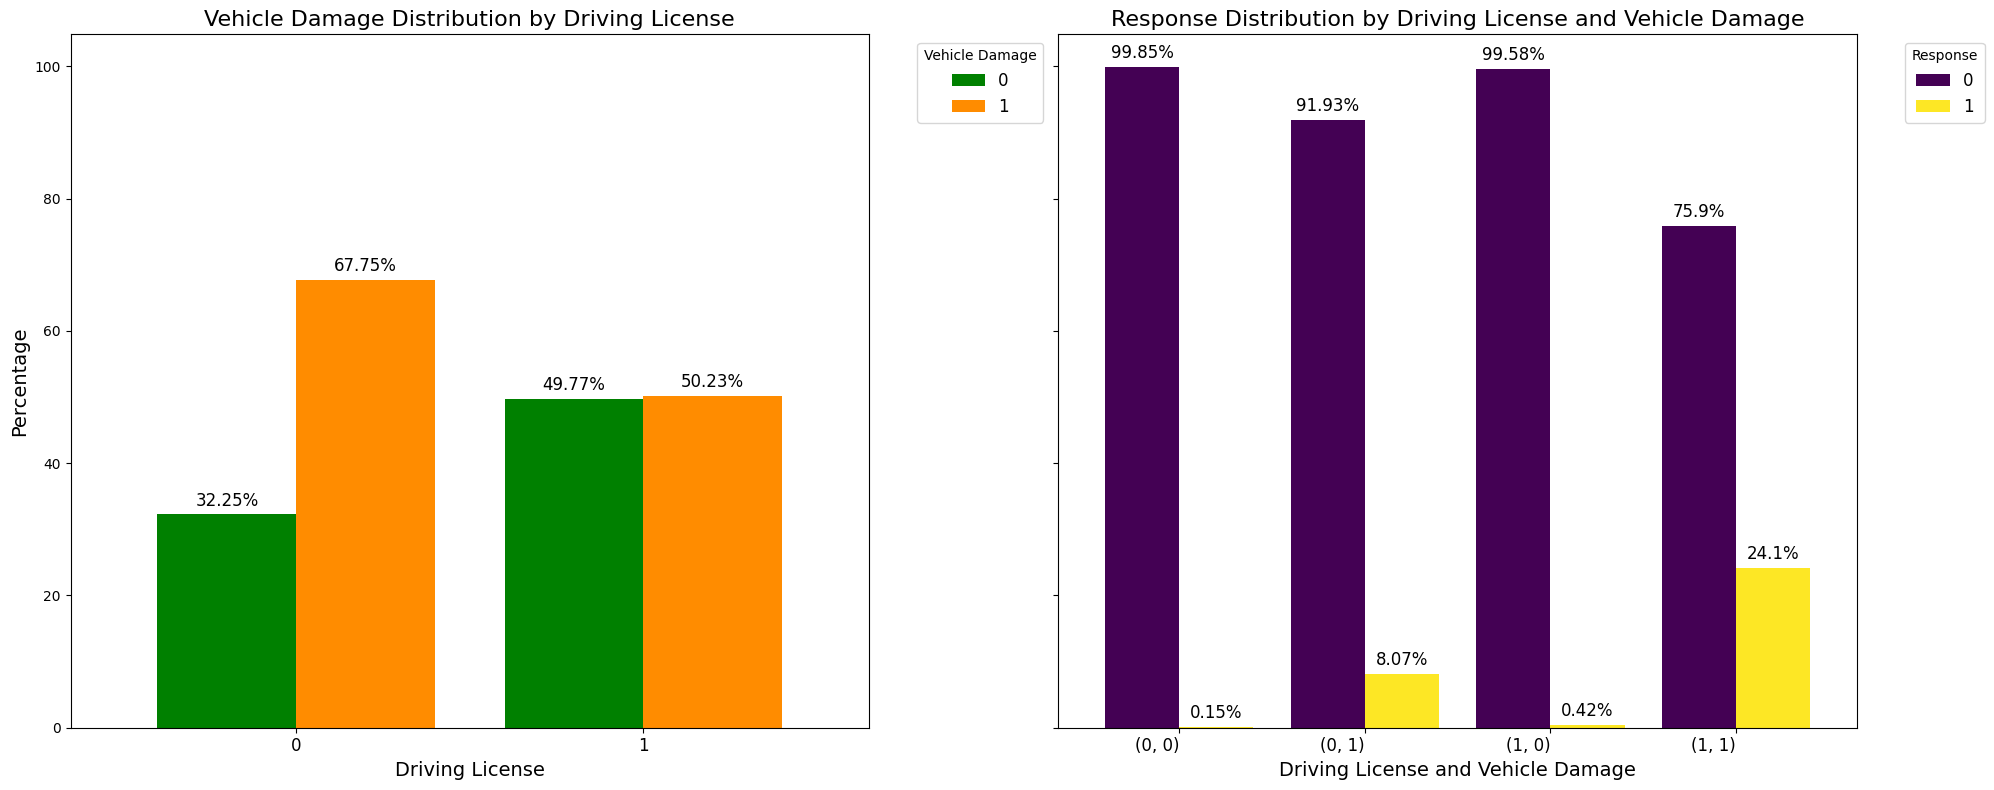

In [7]:
# Define custom colormap: first color green, second color dark orange
custom_cmap = mcolors.ListedColormap(['green', '#FF8C00'])

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Define font sizes
title_fontsize = 16
label_fontsize = 14
tick_fontsize = 12
legend_fontsize = 12

# First plot
new.groupby('Driving_License')['Vehicle_Damage'].value_counts(normalize=True).mul(100).round(2).unstack().plot(kind='bar', ax=ax1, colormap=custom_cmap, width=0.8)

# Adding title and labels to the first plot
ax1.set_title('Vehicle Damage Distribution by Driving License', fontsize=title_fontsize)
ax1.set_xlabel('Driving License', fontsize=label_fontsize)
ax1.set_ylabel('Percentage', fontsize=label_fontsize)
ax1.legend(title='Vehicle Damage', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=legend_fontsize)
ax1.set_xticks(ax1.get_xticks())  # Ensure all xticks are visible
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0, fontsize=tick_fontsize)

# Annotating the bars with percentage values in the first plot
for p in ax1.patches:
    ax1.annotate(f'{p.get_height()}%', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', 
                 xytext=(0, 10), 
                 textcoords='offset points', 
                 fontsize=tick_fontsize)

# Second plot
new.groupby(['Driving_License', 'Vehicle_Damage'])['Response'].value_counts(normalize=True).mul(100).round(2).unstack().plot(kind='bar', ax=ax2, colormap='viridis', width=0.8)

# Adding title and labels to the second plot
ax2.set_title('Response Distribution by Driving License and Vehicle Damage', fontsize=title_fontsize)
ax2.set_xlabel('Driving License and Vehicle Damage', fontsize=label_fontsize)
ax2.set_ylabel('Percentage', fontsize=label_fontsize)
ax2.legend(title='Response', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=legend_fontsize)
ax2.set_xticks(ax2.get_xticks())  # Ensure all xticks are visible
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0, ha='right', fontsize=tick_fontsize)

# Annotating the bars with percentage values in the second plot
for p in ax2.patches:
    height = p.get_height()
    if height > 0:  # Only annotate if the height is greater than 0
        ax2.annotate(f'{height}%', 
                     (p.get_x() + p.get_width() / 2., height), 
                     ha='center', va='center', 
                     xytext=(0, 10), 
                     textcoords='offset points', 
                     fontsize=tick_fontsize)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### Key Insights:
- **No Driving License**: Those without a driving license tend to have more vehicle damage (67.75%) compared to those with a license (50.23%). This may indicate riskier behavior or less driving experience.
- **Impact on Interest**: For customers without a driving license, interest in the insurance offer rises significantly (from 0.15% to 8%) when their vehicle has been damaged. For those with a license, interest jumps from 0.42% to 24.1%.

This suggests that customers with previous accidents, regardless of having a driving license, are more likely to respond positively to insurance offers. Vehicle damage is a strong motivator for increased interest, especially for those without a license, where the response rate sees an 8-fold increase.

# Driving License vs Previously Insured

In this section, we explore the relationship between having a driving license and whether a customer was previously insured. We also assess how this combination impacts customer responses to insurance offers.

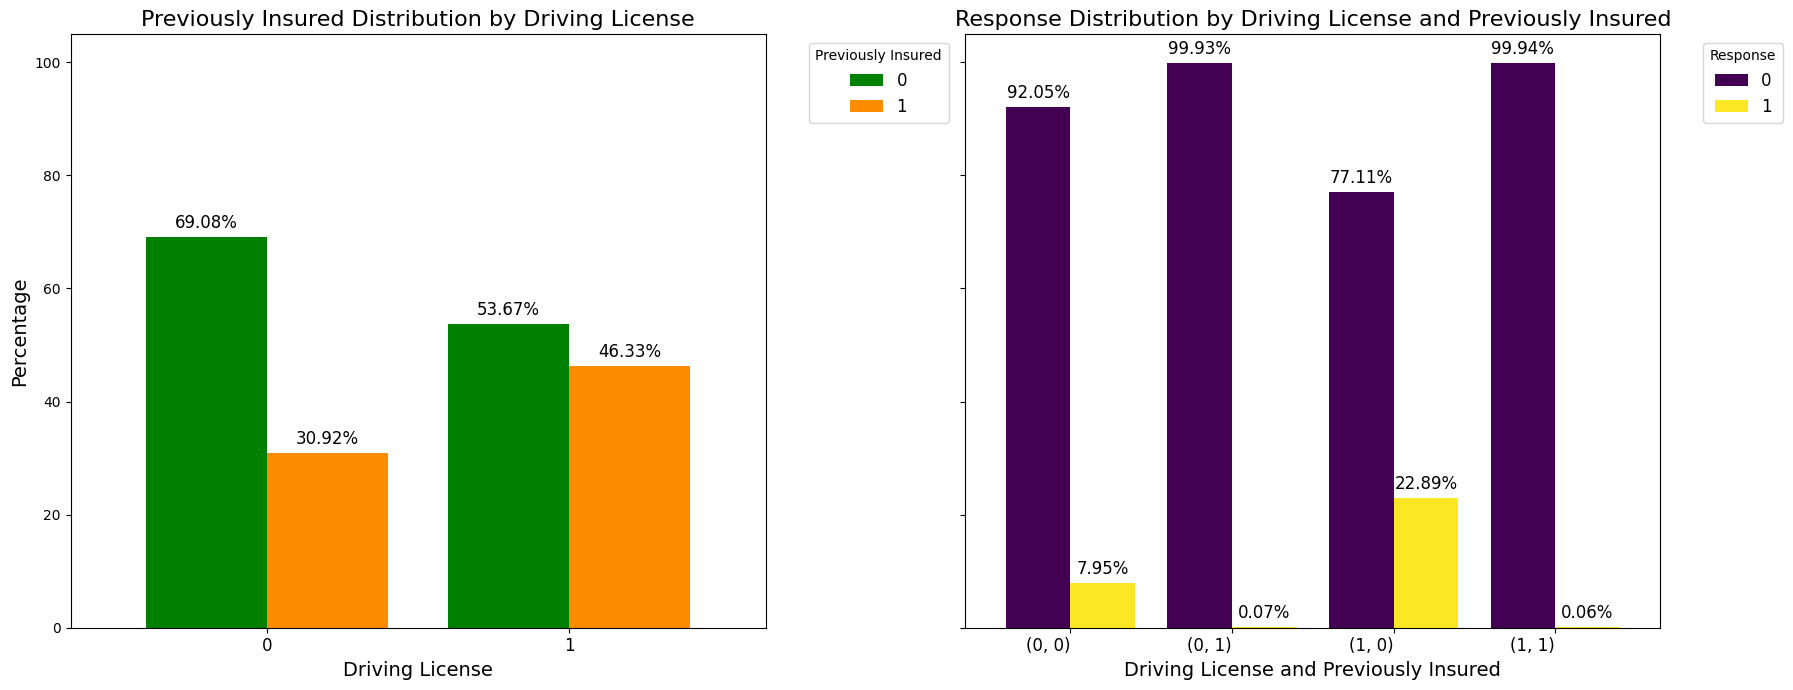

In [8]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

# First plot: Driving_License vs. Previously_Insured
data1 = new.groupby('Driving_License')['Previously_Insured'].value_counts(normalize=True).mul(100).round(2).unstack()
data1.plot(kind='bar', ax=ax1, colormap=custom_cmap, width=0.8)

# Adding title and labels to the first plot
ax1.set_title('Previously Insured Distribution by Driving License', fontsize=title_fontsize)
ax1.set_xlabel('Driving License', fontsize=label_fontsize)
ax1.set_ylabel('Percentage', fontsize=label_fontsize)
ax1.legend(title='Previously Insured', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=legend_fontsize)
ax1.set_xticks(ax1.get_xticks())  # Ensure all xticks are visible
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0, fontsize=tick_fontsize)

# Annotating the bars with percentage values in the first plot
for p in ax1.patches:
    ax1.annotate(f'{p.get_height()}%', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', 
                 xytext=(0, 10), 
                 textcoords='offset points', 
                 fontsize=tick_fontsize)

# Second plot: Driving_License and Previously_Insured vs. Response
data2 = new.groupby(['Driving_License', 'Previously_Insured'])['Response'].value_counts(normalize=True).mul(100).round(2).unstack()
data2.plot(kind='bar', ax=ax2, colormap='viridis', width=0.8)

# Adding title and labels to the second plot
ax2.set_title('Response Distribution by Driving License and Previously Insured', fontsize=title_fontsize)
ax2.set_xlabel('Driving License and Previously Insured', fontsize=label_fontsize)
ax2.set_ylabel('Percentage', fontsize=label_fontsize)
ax2.legend(title='Response', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=legend_fontsize)
ax2.set_xticks(ax2.get_xticks())  # Ensure all xticks are visible
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0, ha='right', fontsize=tick_fontsize)

# Annotating the bars with percentage values in the second plot
for p in ax2.patches:
    height = p.get_height()
    if height > 0:  # Only annotate if the height is greater than 0
        ax2.annotate(f'{height}%', 
                     (p.get_x() + p.get_width() / 2., height), 
                     ha='center', va='center', 
                     xytext=(0, 10), 
                     textcoords='offset points', 
                     fontsize=tick_fontsize)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### Key Insights:
- **Previously Insured Distribution**: Customers without a driving license tend to be uninsured (69.08%) compared to those with a license (46.33%). This may indicate that those without licenses are less likely to purchase insurance.
- **Response to Insurance Offers**: 
  - Customers without a license and previously uninsured show an 8-fold interest increase in insurance when targeted with an offer.
  - For those with a driving license and previously uninsured, the interest jumps 23-fold. 
  - Having prior insurance reduces the likelihood of responding positively to new offers, regardless of driving license status.

These insights suggest that first-time insurance customers, especially those who have just obtained a driving license, are much more likely to respond to insurance offers, particularly if they were previously uninsured.

# Age_Bins vs Vehicle_Age: Correlation = 0.8

In this section, we explore the relationship between age and vehicle age by binning the age column into 7 bins and analyzing the correlation of 0.8 between these variables. We also visualize how age distribution relates to customer response.

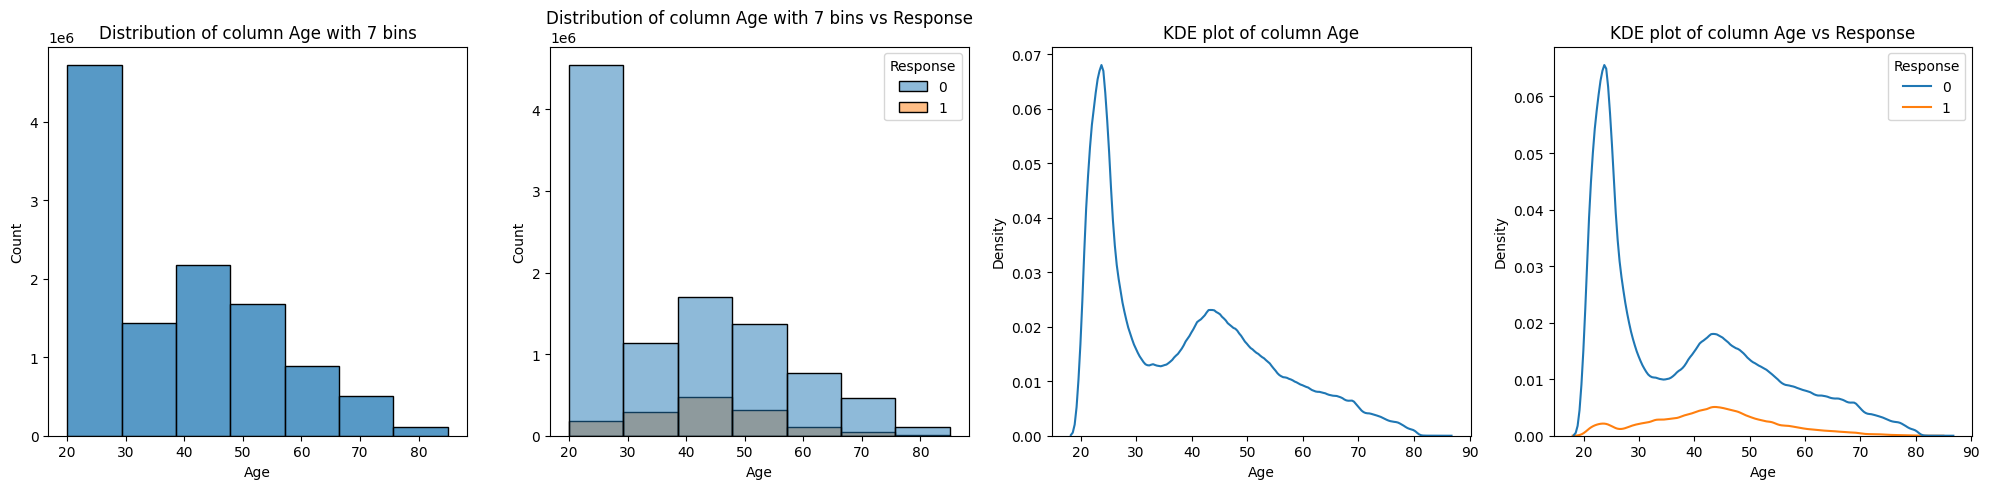

In [9]:
more = [i for i in train.columns if i not in less]
more

fig, ax = plt.subplots(1, 4, figsize=(20, 5))
sns.histplot(x='Age', data=train, bins=7, ax=ax[0])
ax[0].set_title('Distribution of column Age with 7 bins')
sns.histplot(x='Age', data=train, bins=7, ax=ax[1], hue='Response')
ax[1].set_title('Distribution of column Age with 7 bins vs Response')
sns.kdeplot(x='Age', data=train, ax=ax[2])
ax[2].set_title('KDE plot of column Age')
sns.kdeplot(x='Age', data=train, ax=ax[3], hue='Response')
ax[3].set_title('KDE plot of column Age vs Response')

plt.tight_layout()
plt.show()

new['age_bins'] = pd.cut(new['Age'], bins=7)
new['Age_Type'] = new['age_bins'].cat.codes

### Key Insights:
- **Age Distribution**: The age distribution shows that the majority of customers are under 30, with progressively fewer customers in older age groups.
- **Response Distribution**: Customers below 30 years of age have a higher negative response rate to the insurance offers, while the response becomes more balanced across the age groups over 30.
- **Binning Age**: Dividing the age into bins allows us to observe similar patterns in both histograms and KDE plots, indicating the relationship between customer age and their response behavior.

This analysis suggests that younger customers are less likely to respond positively to insurance offers, which could guide targeted marketing strategies for different age groups.

# Age_Type vs Vehicle_Age

This section explores the relationship between different age types (binned age groups) and vehicle age. We aim to understand how age influences the type of vehicle owned by customers.

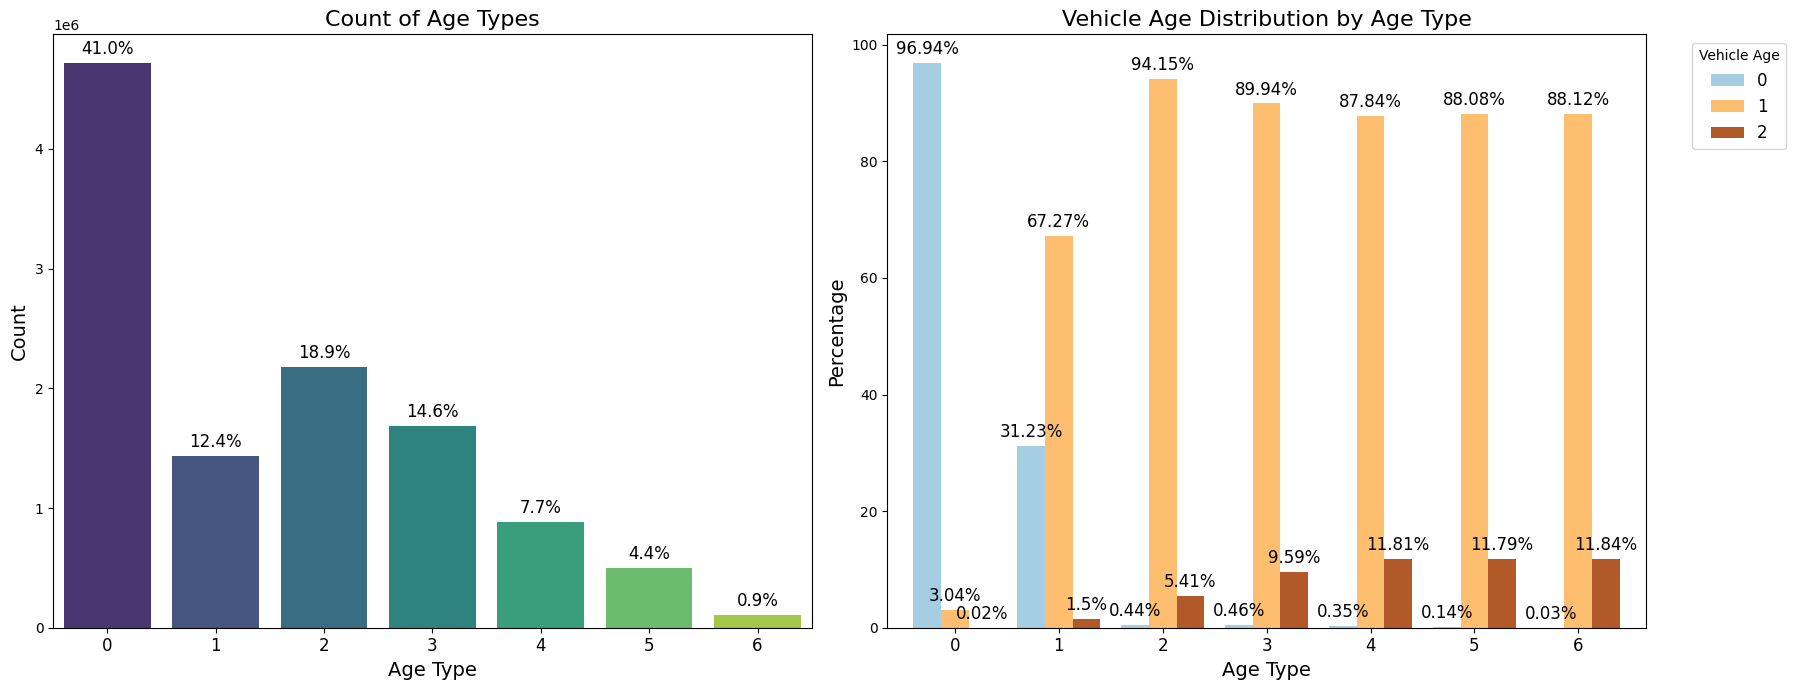

In [10]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# First plot: Age_Type count plot (Seaborn)
sns.countplot(x='Age_Type', data=new, ax=ax1, palette='viridis')

total_counts = new['Age_Type'].value_counts()

# Annotate the bars with percentage values in the count plot
for p in ax1.patches:
    height = p.get_height()
    percentage = (height / total_counts.sum()) * 100
    ax1.annotate(f'{percentage:.1f}%', 
                 (p.get_x() + p.get_width() / 2., height), 
                 ha='center', va='center', 
                 xytext=(0, 10), 
                 textcoords='offset points', 
                 fontsize=tick_fontsize)
    
# Adding title and labels to the first plot
ax1.set_title('Count of Age Types', fontsize=title_fontsize)
ax1.set_xlabel('Age Type', fontsize=label_fontsize)
ax1.set_ylabel('Count', fontsize=label_fontsize)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0, fontsize=tick_fontsize)

# Seconed plot: Age_Type vs. Vehicle_Age
new.groupby('Age_Type')['Vehicle_Age'].value_counts(normalize=True).mul(100).round(2).unstack().plot(kind='bar', ax=ax2, colormap='Paired', width=0.8)

# Adding title and labels to the second plot
ax2.set_title('Vehicle Age Distribution by Age Type', fontsize=title_fontsize)
ax2.set_xlabel('Age Type', fontsize=label_fontsize)
ax2.set_ylabel('Percentage', fontsize=label_fontsize)
ax2.legend(title='Vehicle Age', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=legend_fontsize)
ax2.set_xticks(ax2.get_xticks())  # Ensure all xticks are visible
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0, fontsize=tick_fontsize)

# Annotating the bars with percentage values in the first plot
for p in ax2.patches:
    ax2.annotate(f'{p.get_height()}%', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', 
                 xytext=(0, 10), 
                 textcoords='offset points', 
                 fontsize=tick_fontsize)
    
# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### Key Insights:
- **Age Type Distribution**: 
  - The majority of customers fall into Age Type 0 (41%), representing younger individuals.
  - As age type increases, the count of customers in each bin decreases.

- **Vehicle Age Distribution**:
  - Younger customers (Age Type 0) overwhelmingly own newer vehicles (96.94% of Vehicle Age = 0).
  - As customers get older, they transition to owning older vehicles, with a noticeable increase in Vehicle Age 2 (9.59%) for Age Type 3.

This pattern highlights that younger customers are more likely to purchase new cars, while older customers tend to use older vehicles.

# Age_x_Vehicle vs Response

This section investigates the interaction between age and vehicle age by creating a new feature (`Age_x_Vehicle`) and exploring how it impacts customer responses.

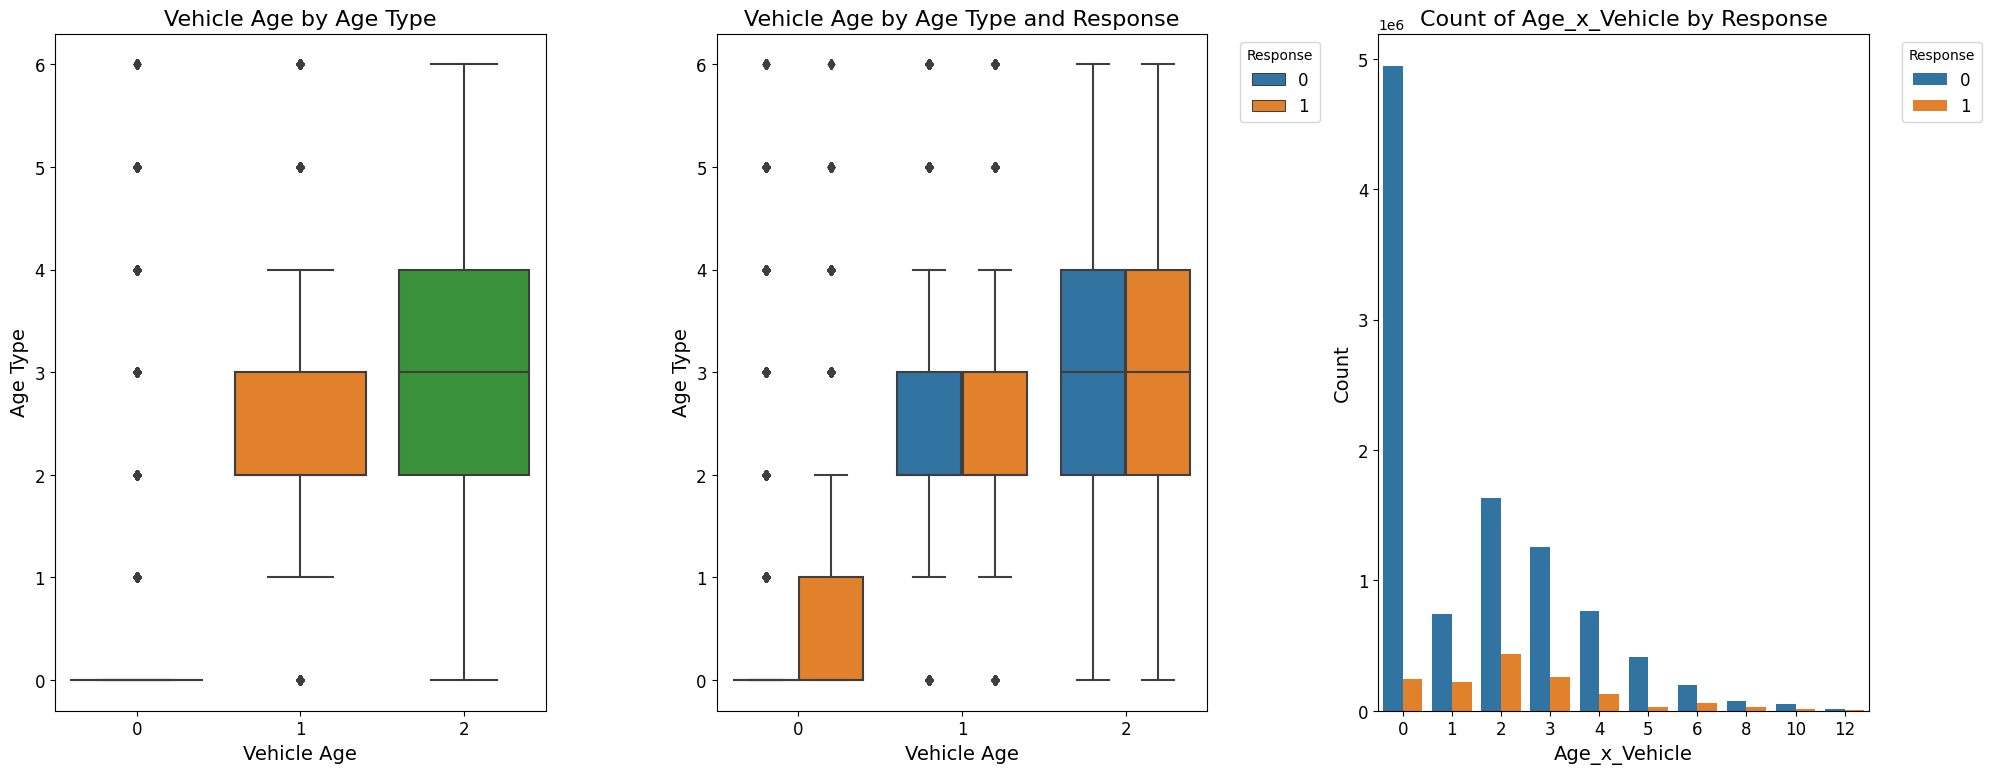

In [11]:
new['Age_x_Vehicle'] = new['Age_Type'] * new['Vehicle_Age'].cat.codes

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))

# Boxplot of Vehicle_Age by Age_Type
sns.boxplot(x='Vehicle_Age', y='Age_Type', data=new, ax=ax1)
ax1.set_title('Vehicle Age by Age Type', fontsize=title_fontsize)
ax1.set_xlabel('Vehicle Age', fontsize=label_fontsize)
ax1.set_ylabel('Age Type', fontsize=label_fontsize)
ax1.tick_params(axis='both', which='major', labelsize=tick_fontsize)

# Boxplot of Vehicle_Age by Age_Type with Response as hue
sns.boxplot(x='Vehicle_Age', y='Age_Type', hue='Response', data=new, ax=ax2)
ax2.set_title('Vehicle Age by Age Type and Response', fontsize=title_fontsize)
ax2.set_xlabel('Vehicle Age', fontsize=label_fontsize)
ax2.set_ylabel('Age Type', fontsize=label_fontsize)
ax2.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax2.legend(title='Response', fontsize=legend_fontsize, bbox_to_anchor=(1.05, 1), loc='upper left')

# Count plot of Age_x_Vehicle with Response as hue
sns.countplot(x='Age_x_Vehicle', hue='Response', data=new, ax=ax3)
ax3.set_title('Count of Age_x_Vehicle by Response', fontsize=title_fontsize)
ax3.set_xlabel('Age_x_Vehicle', fontsize=label_fontsize)
ax3.set_ylabel('Count', fontsize=label_fontsize)
ax3.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax3.legend(title='Response', fontsize=legend_fontsize, bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### Key Insights:
- **Younger Vehicle Age (0 years)**: In most age bins, customers with newer vehicles (0 years) tend to have a higher percentage of non-response (Response 0).
- **Older Vehicle Age (2 years)**: As vehicle age increases, there is a noticeable increase in positive responses (Response 1) across most age bins.
- **Age Extremes**: The youngest age bin (19.9 to 29.3 years) and the oldest age bin (66.4 to 85 years) show higher non-response rates for newer vehicles (Vehicle Age 0).
- **Response Variability**: There is variability in response percentages across different vehicle ages within each age bin, indicating that vehicle age has a significant impact on customer response behavior.

This analysis highlights the complex relationship between customer age, vehicle age, and their likelihood to respond to insurance offers.

# Vehicle Damage vs Previously Insured: Correlation = -0.8

This section explores the relationship between vehicle damage and whether the customer was previously insured, and how this impacts their likelihood to respond to insurance offers.

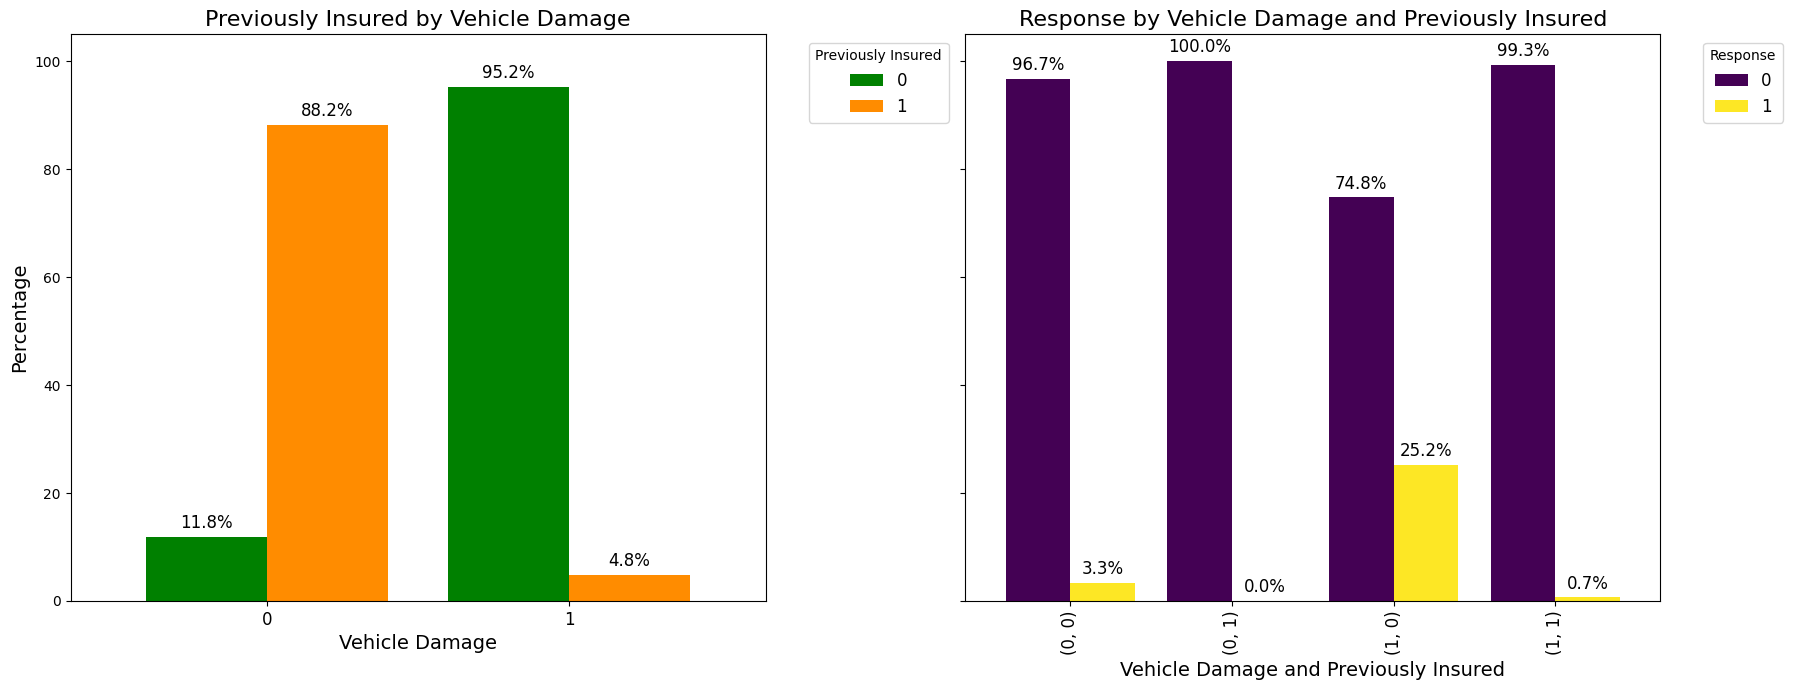

In [12]:
# Calculate the percentages for 'Previously_Insured' by 'Vehicle_Damage'
data1 = new.groupby('Vehicle_Damage')['Previously_Insured'].value_counts(normalize=True).mul(100).round(2).unstack()

# Calculate the percentages for 'Response' by 'Vehicle_Damage' and 'Previously_Insured'
data2 = new.groupby(['Vehicle_Damage', 'Previously_Insured'])['Response'].value_counts(normalize=True).mul(100).round(2).unstack()

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

# Plot clustered bar chart for Previously_Insured
data1.plot(kind='bar', ax=ax1, width=0.8, colormap=custom_cmap)

# Adding title and labels to the first plot
ax1.set_title('Previously Insured by Vehicle Damage', fontsize=title_fontsize)
ax1.set_xlabel('Vehicle Damage', fontsize=label_fontsize)
ax1.set_ylabel('Percentage', fontsize=label_fontsize)
ax1.legend(title='Previously Insured', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=legend_fontsize)
ax1.set_xticks(ax1.get_xticks())  # Ensure all xticks are visible
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0, fontsize=tick_fontsize)

# Annotating the bars with percentage values in the first plot
for p in ax1.patches:
    height = p.get_height()
    ax1.annotate(f'{height:.1f}%', 
                 (p.get_x() + p.get_width() / 2., height), 
                 ha='center', va='center', 
                 xytext=(0, 10), 
                 textcoords='offset points', 
                 fontsize=tick_fontsize)

# Plot clustered bar chart for Response
data2.plot(kind='bar', ax=ax2, width=0.8, colormap='viridis')

# Adding title and labels to the second plot
ax2.set_title('Response by Vehicle Damage and Previously Insured', fontsize=title_fontsize)
ax2.set_xlabel('Vehicle Damage and Previously Insured', fontsize=label_fontsize)
ax2.set_ylabel('Percentage', fontsize=label_fontsize)
ax2.legend(title='Response', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=legend_fontsize)
ax2.set_xticks(ax2.get_xticks())  # Ensure all xticks are visible
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90, fontsize=tick_fontsize)

# Annotating the bars with percentage values in the second plot
for p in ax2.patches:
    height = p.get_height()
    ax2.annotate(f'{height:.1f}%', 
                 (p.get_x() + p.get_width() / 2., height), 
                 ha='center', va='center', 
                 xytext=(0, 10), 
                 textcoords='offset points', 
                 fontsize=tick_fontsize)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### Key Insights:
- **Previously Insured by Vehicle Damage**: 
  - 88.2% of customers with vehicle damage were previously insured, while only 11.8% were not. 
  - Conversely, 95.2% of customers without vehicle damage were not previously insured.
  
- **Response by Vehicle Damage and Previously Insured**:
  - For customers with no previous insurance and no vehicle damage, 96.7% did not respond to the offer, while only 3.3% responded.
  - Customers with both vehicle damage and no previous insurance had the highest positive response rate (25.2%).
  - Almost no positive responses were observed for customers who had both previous insurance and vehicle damage.

This analysis highlights that customers who experience vehicle damage but do not have previous insurance are more likely to respond to insurance offers, making them a key target group for new offers.

# Policy Sales Channel vs Age Bins: Correlation = -0.656080

This section analyzes the relationship between age bins (Age Type) and the Policy Sales Channel. The correlation of -0.656080 suggests a moderate negative relationship between these variables, indicating that as age increases, the preferred policy sales channels shift.

### Key Insights:
- **Policy Sales Channel by Age Type**:
  - Younger customers (Age Type 0 and 1) tend to prefer policy channels with higher values (closer to 160), while older customers (Age Types 2 and beyond) tend to use channels with lower values.
  - There are more outliers in Policy Sales Channels for younger customers, indicating that they may experiment with a variety of channels before settling on a preferred one.

- **Policy Sales Channel by Age Type and Response**:
  - Both positive (Response 1) and negative (Response 0) responses are spread across similar policy sales channels for older customers (Age Types 2 and beyond), showing no significant preference for one type of channel over another.
  - Younger customers (Age Type 1) who prefer higher policy sales channels show a stronger positive response compared to other groups.

This analysis suggests that marketing strategies should focus on specific channels based on customer age, with younger customers responding better to higher-numbered channels and older customers showing more consistent behavior across different channels.

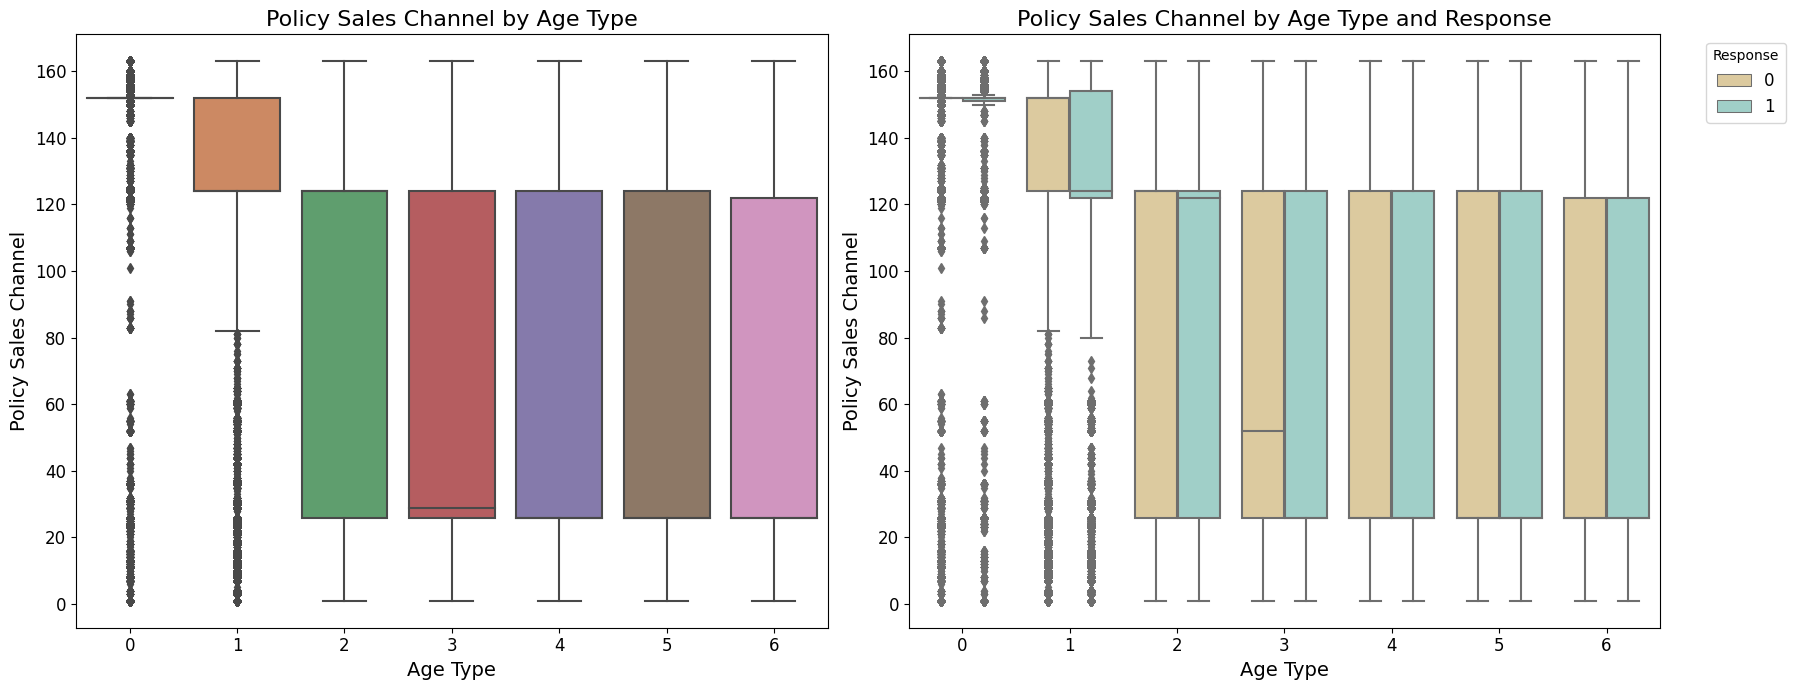

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
# First plot: Boxplot of Age_Type vs. Policy_Sales_Channel
sns.boxplot(x='Age_Type', y='Policy_Sales_Channel', data=new, ax=ax1, palette='deep')
ax1.set_title('Policy Sales Channel by Age Type', fontsize=title_fontsize)
ax1.set_xlabel('Age Type', fontsize=label_fontsize)
ax1.set_ylabel('Policy Sales Channel', fontsize=label_fontsize)
ax1.tick_params(axis='both', which='major', labelsize=tick_fontsize)

# Second plot: Boxplot of Age_Type vs. Policy_Sales_Channel with Response as hue
sns.boxplot(x='Age_Type', y='Policy_Sales_Channel', hue='Response', data=new, ax=ax2, palette='BrBG')
ax2.set_title('Policy Sales Channel by Age Type and Response', fontsize=title_fontsize)
ax2.set_xlabel('Age Type', fontsize=label_fontsize)
ax2.set_ylabel('Policy Sales Channel', fontsize=label_fontsize)
ax2.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax2.legend(title='Response', fontsize=legend_fontsize, bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### Policy Sales Channel vs Vehicle Age: Correlation = -0.619

#### Code Explanation:
- **First Plot: Boxplot of `Vehicle_Age` vs `Policy_Sales_Channel`**
    - This shows the distribution of different sales channels across the vehicle age bins (`0`, `1`, `2`).

- **Second Plot: Boxplot of `Vehicle_Age` vs `Policy_Sales_Channel` with `Response` as the hue**
    - Here, the plot includes the customer's response (interested or not) for each sales channel and vehicle age.

#### Insights:
- The **Policy Sales Channel** values remain relatively stable for vehicle ages `1` and `2`. However, younger vehicles (`0` age) tend to have a slightly narrower range, as seen in the first plot.
  
- In the second plot, there is some variation between responses (`0` and `1`), but overall the distribution of Policy Sales Channels across Vehicle Ages remains fairly uniform, suggesting a low impact of vehicle age on how a policy is sold.
  
- The spread in vehicle age `0` seems to have more variance in responses compared to age `1` and `2`.

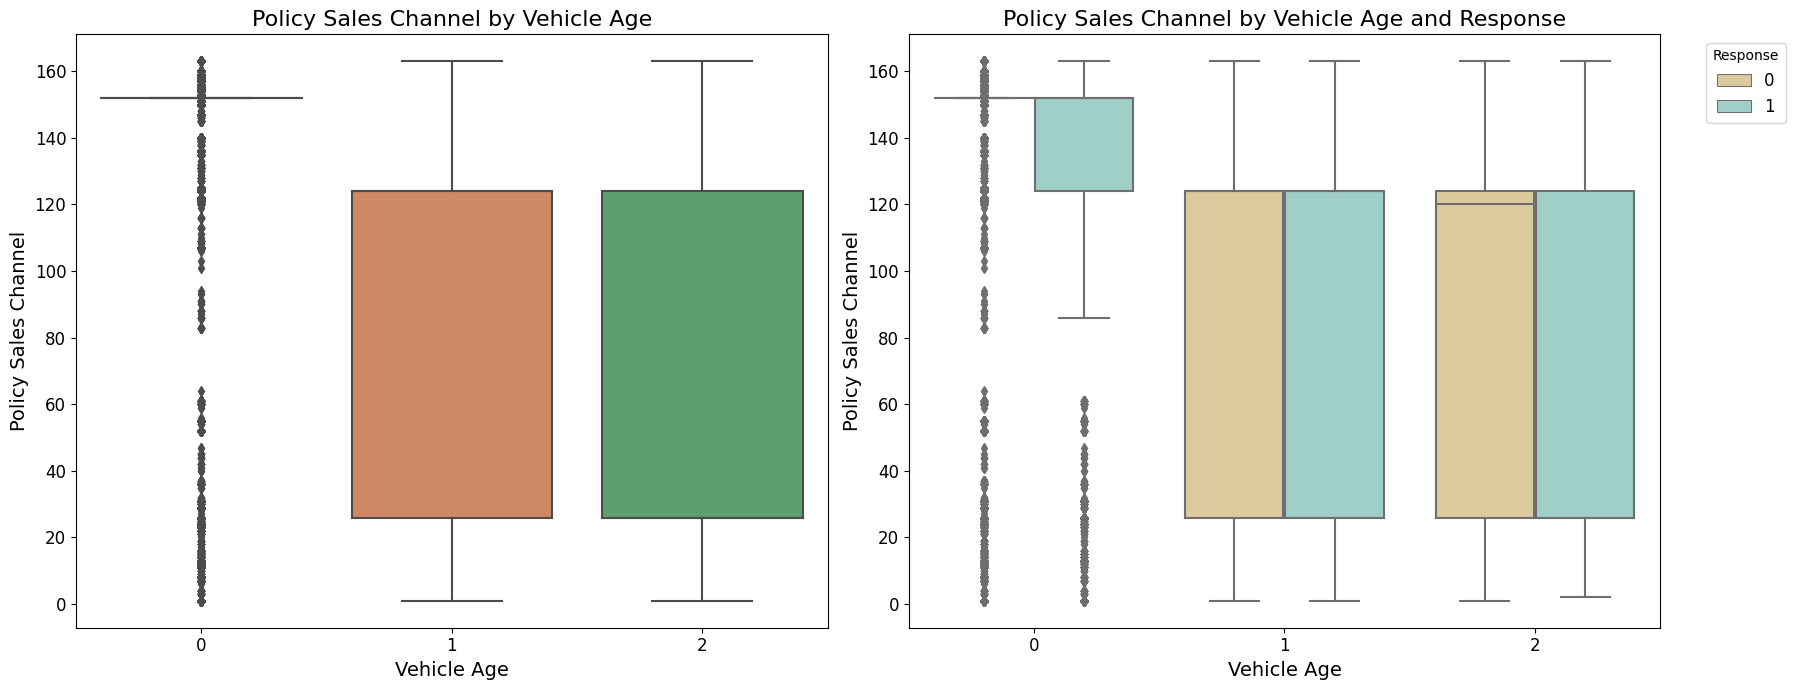

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
# First plot: Boxplot of Vehicle_Age vs. Policy_Sales_Channel
sns.boxplot(x='Vehicle_Age', y='Policy_Sales_Channel', data=new, ax=ax1, palette='deep')
ax1.set_title('Policy Sales Channel by Vehicle Age', fontsize=title_fontsize)
ax1.set_xlabel('Vehicle Age', fontsize=label_fontsize)
ax1.set_ylabel('Policy Sales Channel', fontsize=label_fontsize)
ax1.tick_params(axis='both', which='major', labelsize=tick_fontsize)

# Second plot: Boxplot of Vehicle_Age vs. Policy_Sales_Channel with Response as hue
sns.boxplot(x='Vehicle_Age', y='Policy_Sales_Channel', hue='Response', data=new, ax=ax2, palette='BrBG')
ax2.set_title('Policy Sales Channel by Vehicle Age and Response', fontsize=title_fontsize)
ax2.set_xlabel('Vehicle Age', fontsize=label_fontsize)
ax2.set_ylabel('Policy Sales Channel', fontsize=label_fontsize)
ax2.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax2.legend(title='Response', fontsize=legend_fontsize, bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Feature Distribution

## Key Insights

### 1. **Annual_Premium**
   - **Boxplot Analysis**: 
     - Most of the annual premium values are concentrated below 100,000, with a few extreme outliers reaching up to 500,000.
   - **KDE Plot Analysis**:
     - Higher annual premiums show a lower response rate (orange line). The majority of customer responses to the policy (Response 1) are within the lower premium range.

### 2. **Policy_Sales_Channel**
   - **Boxplot Analysis**: 
     - Policy sales channels are concentrated around a few specific channels.
   - **KDE Plot Analysis**:
     - Certain channels, such as channel 150, have a higher likelihood of engagement (Response 1), as shown by spikes in the distribution.

### 3. **Vintage**
   - **Boxplot Analysis**: 
     - The vintage distribution is uniform across values with no major outliers.
   - **KDE Plot Analysis**:
     - Vehicles in the lower vintage range show a slightly higher response rate (Response 1), but overall, Response 0 dominates across all vintage values.

This analysis provides a clear visual representation of how features like **Annual_Premium**, **Policy_Sales_Channel**, and **Vintage** are distributed and their relationship with customer responses.


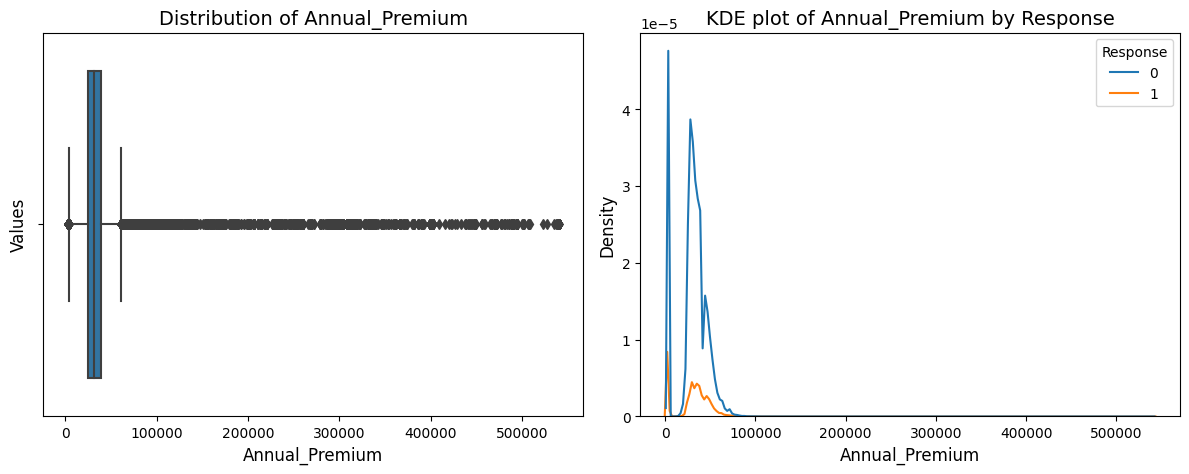

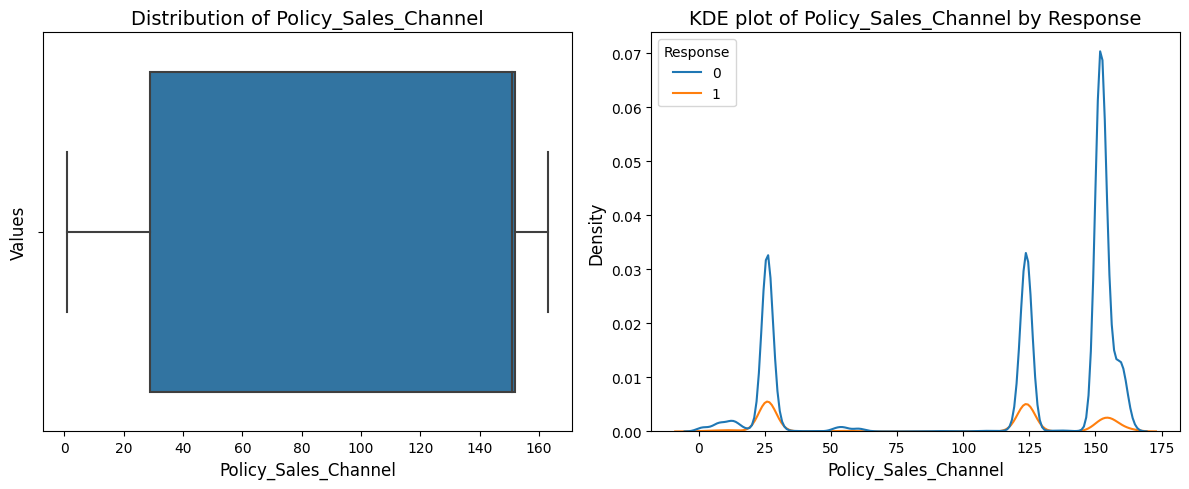

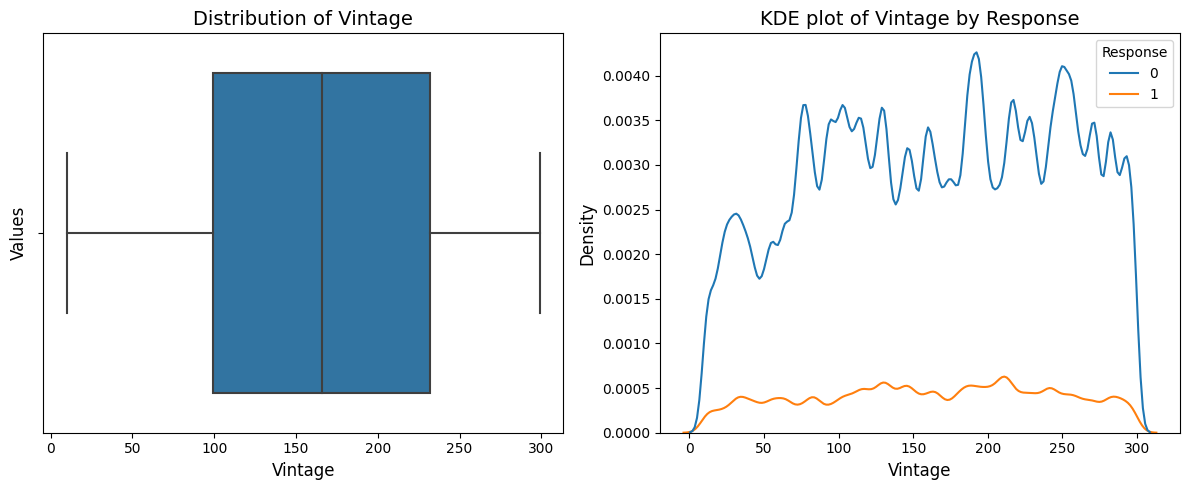

In [15]:
num = ['Annual_Premium', 'Policy_Sales_Channel', 'Vintage']
for i in num:
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))       
    # Plotting the first boxplot
    sns.boxplot(x=i, data=new, ax=ax[0])
    ax[0].set_title(f'Distribution of {i}', fontsize=14)
    ax[0].set_xlabel(i, fontsize=12)
    ax[0].set_ylabel('Values', fontsize=12)    
    # Plotting the second KDE plot with hue='Response'
    sns.kdeplot(x=i, data=new, hue='Response', ax=ax[1])
    ax[1].set_title(f'KDE plot of {i} by Response', fontsize=14)
    ax[1].set_xlabel(i, fontsize=12)
    ax[1].set_ylabel('Density', fontsize=12)    
    plt.tight_layout()
    plt.show()

# Target Feature: Response

### Key Insights:
- The **countplot** visualizes the distribution of the target feature `Response`.
- **87.70%** of the total instances correspond to `Response = 0`, indicating a majority of customers who did not respond to the policy offer.
- **12.30%** of the total instances correspond to `Response = 1`, representing the minority of customers who showed interest in the policy.
  
This highly imbalanced distribution of the target feature will need to be addressed in any modeling process, as the class imbalance could affect model performance, especially when predicting the minority class (`Response = 1`).

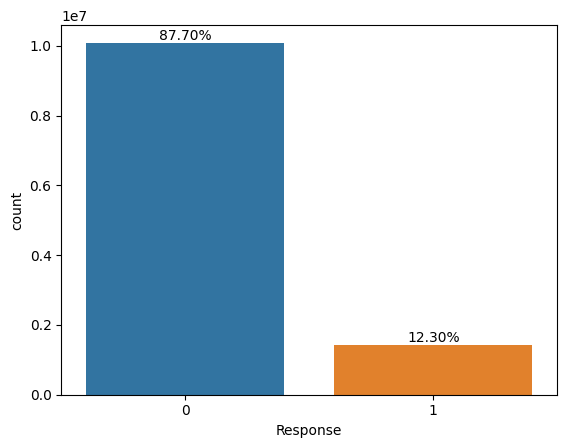

In [16]:
fig, ax = plt.subplots()
sns.countplot(x='Response', data=train, ax=ax)

# Calculate the total number of instances
total = len(train)

# Add percentages on top of the bars
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.2f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 5  # Adjust the position above the bar
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

# Conclusion from EDA:

- **Driving License vs Vehicle Damage**: When a vehicle is damaged, there is a significant increase in customer interest. For people **without a driving license**, interest rises from **0.15% to 8%** (an 8-fold increase). For people **with a driving license**, interest rises from **0.42% to 24%** (a 24-fold increase).

- **Driving License vs Previously Insured**: Uninsured vehicles show a much higher interest in policy offers compared to insured vehicles. Specifically, interest for uninsured vehicles **without a driving license** is 8 times higher, and for uninsured vehicles **with a driving license**, it is **23 times** higher than their insured counterparts.

- **Age Bins vs Vehicle Age**: As vehicle age increases to **2 years**, there tends to be a higher percentage of responses indicating interest (Response = 1) across most age bins.

- **Vehicle Damage vs Previously Insured**: The highest interest in policies is observed for individuals whose vehicles have been damaged and who are not previously insured, with interest increasing **25-fold** for these customers.

# Feature Engineering 

### Breakdown:

1. **Dataset Concatenation:**
   - The training and test datasets are concatenated to apply transformations uniformly across both sets, ensuring consistency in feature engineering.

2. **Category Conversion:**
   - Columns in the `less` list are converted to 'category' dtype to optimize memory usage and prepare for encoding.

3. **Age Binning:**
   - The 'Age' feature is binned into 7 intervals, creating a new feature `age_bins`, which is further encoded into categorical codes stored in `Age_Type`. This captures age group effects instead of treating 'Age' as a continuous variable.

4. **Interaction Features:**
   - New features like `Age_x_Vehicle_Age`, `Age_x_Vehicle_Damage`, and `Age_x_Previously_Insured` are created by multiplying encoded `Age_Type` with other categorical features. This helps capture relationships between age and vehicle-related factors.

5. **Factorization:**
   - Categorical features such as `Policy_Sales_Channel` and `Previously_Insured` are factorized to create numeric representations. This step is necessary for algorithms that require numeric input.

6. **Train-Test Splitting:**
   - After transformation, the original train and test sets are restored by splitting the combined data. `X` holds the features, while `y` contains the target variable (`Response`), ensuring only relevant columns are retained for modeling.

In [17]:
full = pd.concat([train,test],axis=0)

for i in less:
    full[i] = full[i].astype('category')

# Age Binning
full['age_bins'] = pd.cut(full['Age'], bins=7)
full['Age_Type'] = full['age_bins'].cat.codes

# Interaction Features
full['Age_x_Vehicle_Age'] = full['Age_Type'] * full['Vehicle_Age'].cat.codes
full['Age_x_Vehicle_Damage'] = full['Age_Type'] * full['Vehicle_Damage'].cat.codes
full['Age_x_Previously_Insured'] = full['Age_Type'] * full['Previously_Insured'].cat.codes

fac_pre = ['Policy_Sales_Channel','Vehicle_Damage','Annual_Premium','Vintage','Age_Type']
col_pre = []
for i in fac_pre:
    full['Previously_Insured_x_'+i] = pd.factorize(full['Previously_Insured'].astype(str) + full[i].astype(str))[0]
    col_pre.append('Previously_Insured_x_'+i)
    
fac_pro = fac_pre[1:]
col_pro = []
for i in fac_pro:
    full['Policy_Sales_Channel_x_'+i] = pd.factorize(full['Policy_Sales_Channel'].astype(str) + full[i].astype(str))[0]
    col_pro.append('Policy_Sales_Channel_x_'+i)

In [18]:
train_df = full.iloc[:len(train)]
test_df = full.iloc[len(train):]

X = train_df.drop(['Response','age_bins'],axis=1)          
y = train_df['Response']
X

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,...,Age_x_Previously_Insured,Previously_Insured_x_Policy_Sales_Channel,Previously_Insured_x_Vehicle_Damage,Previously_Insured_x_Annual_Premium,Previously_Insured_x_Vintage,Previously_Insured_x_Age_Type,Policy_Sales_Channel_x_Vehicle_Damage,Policy_Sales_Channel_x_Annual_Premium,Policy_Sales_Channel_x_Vintage,Policy_Sales_Channel_x_Age_Type
id,,,,,,,,,,,,,,,,,,,,,
0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,...,0,0,0,0,0,0,0,0,0,0
1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,...,0,1,0,1,1,1,1,1,1,1
2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,...,0,2,1,2,2,2,2,2,2,2
3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,...,0,3,0,3,3,3,3,3,3,3
4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,...,1,2,1,4,4,4,2,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11504793,Male,48,1,6.0,0,1-2 Year,Yes,27412.0,26.0,218,...,0,1,0,5210,144,8,1,40342,1361,14
11504794,Female,26,1,36.0,0,< 1 Year,Yes,29509.0,152.0,115,...,0,4,0,23274,176,0,4,3394,414,2
11504795,Female,29,1,32.0,1,< 1 Year,No,2630.0,152.0,189,...,0,2,1,18,456,2,2,11,52,2


### Preparing the Model Pipeline

In this section, the data is prepared for modeling by splitting the dataset into training and test sets using `train_test_split`. The `ColumnTransformer` is then utilized to apply different transformations to various feature groups:

- **Categorical variables** like 'Gender' and 'Vehicle_Damage' are encoded using `OneHotEncoder`.
- **Numeric variables** such as 'Age' and 'Driving_License' are scaled using `MinMaxScaler`.
- **Ordinal variables** like 'Vehicle_Age' are transformed using `OrdinalEncoder`.
- **Continuous variables** such as 'Annual_Premium' are scaled with `RobustScaler` to handle outliers.
- **Other features** including interaction features (e.g., 'Age_x_Vehicle_Age') are standardized using `StandardScaler`.

The `passthrough` parameter ensures that any columns not specified in the transformers are passed through without transformation, making sure all relevant features are retained for modeling.

In [19]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, RobustScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 512)

coltrans = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['Gender', 'Vehicle_Damage']),
        ('minmax', MinMaxScaler(), ['Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Policy_Sales_Channel', 'Vintage']),
        ('ordinal', OrdinalEncoder(categories=[['< 1 Year', '1-2 Year', '> 2 Years']]), ['Vehicle_Age']),
        ('robust', RobustScaler(), ['Annual_Premium']),
        ('standard', StandardScaler(), ['Age_Type', 'Age_x_Vehicle_Age', 'Age_x_Vehicle_Damage', 'Age_x_Previously_Insured']),
        ('standard_2', StandardScaler(),col_pre+col_pro),            # Version 6:
#         ('standard_3', StandardScaler(),new_stan),
#         ('minmax_2', MinMaxScaler(),new_min)                       # Version 7:
    ],
    remainder='passthrough'  # Keeps columns not specified in transformers
)

coltrans

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat', OneHotEncoder(),
                                 ['Gender', 'Vehicle_Damage']),
                                ('minmax', MinMaxScaler(),
                                 ['Age', 'Driving_License', 'Region_Code',
                                  'Previously_Insured', 'Policy_Sales_Channel',
                                  'Vintage']),
                                ('ordinal',
                                 OrdinalEncoder(categories=[['< 1 Year',
                                                             '1-2 Year',
                                                             '> 2 Years']]),
                                 ['Vehicle_Age']),
                                ('robust', RobustScaler(), ['Annual_...
                                ('standard_2', StandardScaler(),
                                 ['Previously_Insured_x_Policy_Sales_Channel',
                                  'Previously_Insured_x_Vehicle_Damage',
                                  'Previously_Insured_x_Annual_Premium',
                                  'Previously_Insured_x_Vintage',
                                  'Previously_Insured_x_Age_Type',
                                  'Policy_Sales_Channel_x_Vehicle_Damage',
                                  'Policy_Sales_Channel_x_Annual_Premium',
                                  'Policy_Sales_Channel_x_Vintage',
                                  'Policy_Sales_Channel_x_Age_Type'])])

### Applying Transformations and Checking Response Imbalance

- **Fit and Transform**: The `ColumnTransformer` is applied to the training data using `fit_transform()` and to the test data using `transform()`. This ensures that the same transformations are applied consistently across both sets.
  
- **Class Imbalance Check**: The ratio of `Response == 0` to `Response == 1` is calculated to assess class imbalance in the target variable. This is important as imbalanced classes can affect model performance.

- **Transformed DataFrame**: The transformed training data is converted back to a DataFrame using `pd.DataFrame()`, with feature names extracted using `get_feature_names_out()` from the `ColumnTransformer`.

In [20]:
X_train_trans = coltrans.fit_transform(X_train)
X_test_trans = coltrans.transform(X_test)

ratio = len(train[train['Response']==0]) / len(train[train['Response']==1])
ratio

pd.DataFrame(X_train_trans,columns=coltrans.get_feature_names_out())

,cat__Gender_Female,cat__Gender_Male,cat__Vehicle_Damage_No,cat__Vehicle_Damage_Yes,minmax__Age,minmax__Driving_License,minmax__Region_Code,minmax__Previously_Insured,minmax__Policy_Sales_Channel,minmax__Vintage,...,standard__Age_x_Previously_Insured,standard_2__Previously_Insured_x_Policy_Sales_Channel,standard_2__Previously_Insured_x_Vehicle_Damage,standard_2__Previously_Insured_x_Annual_Premium,standard_2__Previously_Insured_x_Vintage,standard_2__Previously_Insured_x_Age_Type,standard_2__Policy_Sales_Channel_x_Vehicle_Damage,standard_2__Policy_Sales_Channel_x_Annual_Premium,standard_2__Policy_Sales_Channel_x_Vintage,standard_2__Policy_Sales_Channel_x_Age_Type
0,1.0,0.0,0.0,1.0,0.353846,1.0,0.538462,0.0,0.154321,0.363322,...,-0.414247,-0.432120,-0.892909,-0.411167,-0.540301,-0.802372,-0.425781,0.054069,-0.493784,-0.451111
1,1.0,0.0,1.0,0.0,0.076923,1.0,0.153846,1.0,0.932099,0.878893,...,-0.414247,-0.380437,0.526480,0.477098,-1.488719,-0.523165,-0.373957,-0.238491,-0.541267,-0.432163
2,0.0,1.0,1.0,0.0,0.569231,1.0,0.250000,1.0,0.154321,0.716263,...,2.158594,0.343123,0.526480,-0.928375,0.204884,2.268902,0.040629,-0.656232,-0.545848,-0.204781
3,1.0,0.0,0.0,1.0,0.307692,1.0,0.153846,0.0,0.759259,0.256055,...,-0.414247,-0.483803,-0.892909,-0.333583,0.777630,-0.802372,-0.477604,-0.161605,-0.375077,-0.223729
4,0.0,1.0,0.0,1.0,0.384615,1.0,0.269231,0.0,0.154321,0.491349,...,-0.414247,-0.432120,-0.892909,0.131031,-1.476402,-0.802372,-0.425781,-0.358861,-0.566258,-0.451111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8628593,0.0,1.0,1.0,0.0,0.061538,1.0,0.942308,0.0,0.925926,0.217993,...,-0.414247,0.859953,1.945869,-0.890918,1.430437,-1.081579,1.750797,0.102796,0.215959,0.268931
8628594,1.0,0.0,0.0,1.0,0.061538,1.0,0.288462,1.0,0.932099,0.363322,...,-0.414247,-0.380437,3.365258,-0.928375,0.377324,-0.523165,-0.270311,-0.656206,-0.403817,-0.432163
8628595,0.0,1.0,0.0,1.0,0.307692,1.0,0.538462,0.0,0.074074,0.626298,...,-0.414247,2.048660,-0.892909,-0.351114,0.352689,-0.802372,2.113560,5.148157,0.866556,0.780541
8628596,0.0,1.0,1.0,0.0,0.092308,1.0,0.346154,1.0,0.932099,0.640138,...,-0.414247,-0.380437,0.526480,0.155018,-0.534143,-0.523165,-0.373957,-0.205285,-0.493367,-0.432163


### Exploring XGBoost, CatBoost, and LightGBM Models:

For each model, we will follow a consistent process:
1. **Apply the model** to the dataset.
2. **Obtain feature importance** to understand the key contributing factors.
3. **Plot the ROC AUC curve** to evaluate the model's performance.

## XGBoost:

In [21]:
import xgboost as xgb

#### From optuna

xgbc = xgb.XGBClassifier(
    random_state=512,
    objective="binary:logistic",
    eval_metric='auc',
    max_depth=8,
    min_child_weight=12,  # Equivalent to min_samples_leaf
    use_label_encoder=False, n_estimators = 2155,
    colsample_bytree = 0.5, gamma = 0.2, 
    learning_rate = 0.09093568107192034, subsample = 1.0,
    reg_alpha = 0.0011852827097616767, 
    reg_lambda = 1.0735757602378362e-06,
    early_stopping_rounds=10,
    max_bin = 197818,
    scale_pos_weight = ratio,
)

In [22]:
xgbc.fit(X_train_trans,y_train, 
         eval_set=[(X_test_trans, y_test)],  # Validation set
         verbose=50  # Print messages during training
)
y_pred_xgb = xgbc.predict_proba(X_test_trans)

print('ROC_AUC_Score XGBoost train: ',round(roc_auc_score(y_train,xgbc.predict_proba(X_train_trans)[:,1]) * 100,2))
print('ROC_AUC_Score XGBoost test: ',round(roc_auc_score(y_test,xgbc.predict_proba(X_test_trans)[:,1]) * 100,2))

[0]	validation_0-auc:0.84943
[50]	validation_0-auc:0.87141
[100]	validation_0-auc:0.87671
[150]	validation_0-auc:0.87956
[200]	validation_0-auc:0.88103
[250]	validation_0-auc:0.88207
[300]	validation_0-auc:0.88297
[350]	validation_0-auc:0.88396
[400]	validation_0-auc:0.88440
[450]	validation_0-auc:0.88493
[500]	validation_0-auc:0.88544
[550]	validation_0-auc:0.88584
[600]	validation_0-auc:0.88619
[650]	validation_0-auc:0.88653
[700]	validation_0-auc:0.88681
[750]	validation_0-auc:0.88706
[800]	validation_0-auc:0.88729
[850]	validation_0-auc:0.88760
[900]	validation_0-auc:0.88783
[950]	validation_0-auc:0.88796
[1000]	validation_0-auc:0.88805
[1050]	validation_0-auc:0.88820
[1100]	validation_0-auc:0.88837
[1137]	validation_0-auc:0.88846
ROC_AUC_Score XGBoost train:  89.74
ROC_AUC_Score XGBoost test:  88.85


In [23]:
### # Get feature importances
feature_importances = xgbc.feature_importances_

# Get feature names
feature_names = coltrans.get_feature_names_out()

# Create a DataFrame for the feature importances
feature_importance_xgb = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
})

# Sort the DataFrame by importance
feature_importance_xgb = feature_importance_xgb.sort_values(by='importance', ascending=False)

# Print the DataFrame
feature_importance_xgb

,feature,importance
7,minmax__Previously_Insured,0.354873
17,standard_2__Previously_Insured_x_Vehicle_Damage,0.267542
3,cat__Vehicle_Damage_Yes,0.209609
2,cat__Vehicle_Damage_No,0.096276
15,standard__Age_x_Previously_Insured,0.016388
14,standard__Age_x_Vehicle_Damage,0.014773
21,standard_2__Policy_Sales_Channel_x_Vehicle_Damage,0.008108
20,standard_2__Previously_Insured_x_Age_Type,0.006604
4,minmax__Age,0.003494
12,standard__Age_Type,0.003335


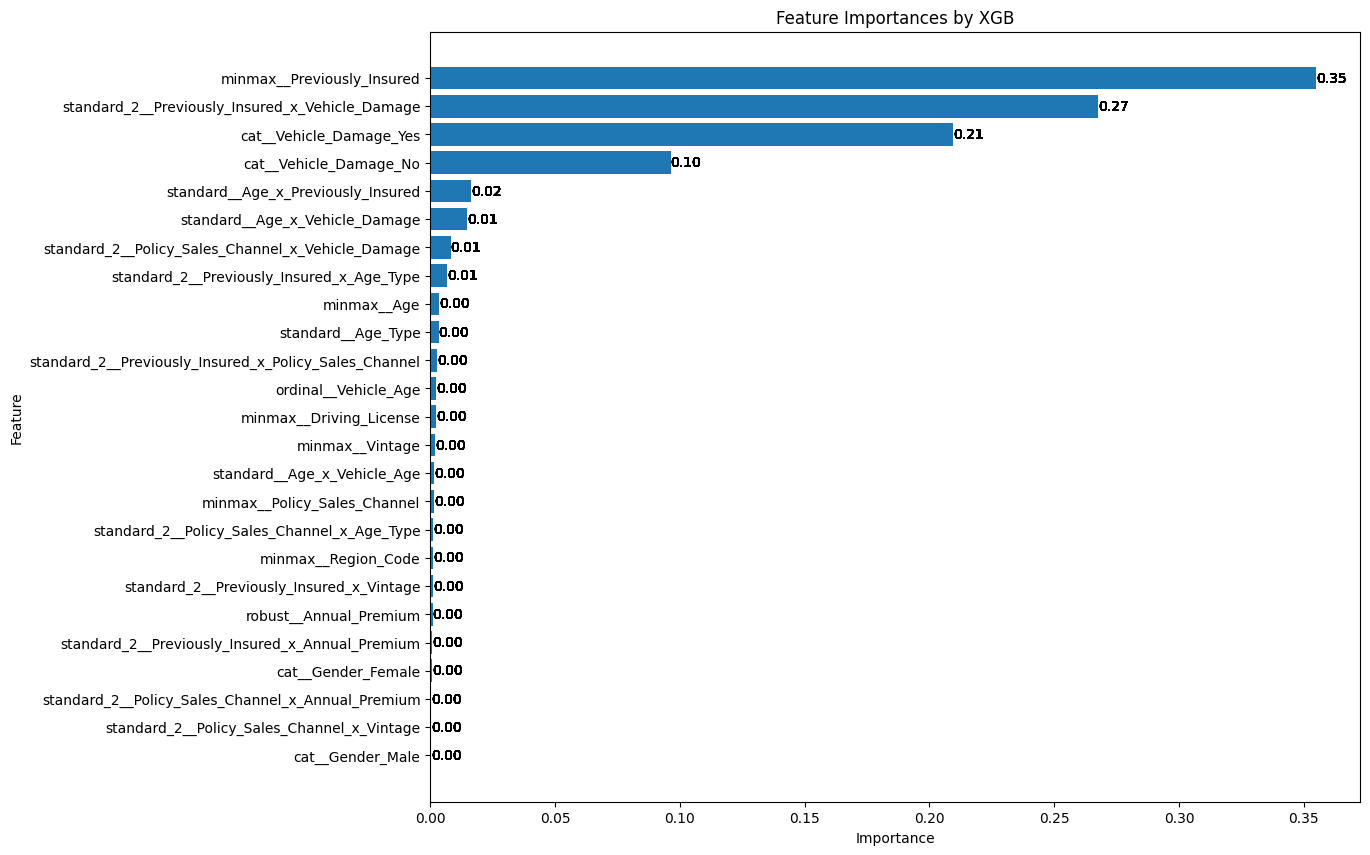

In [24]:
# Assuming feature_importance_xgb is a DataFrame with columns 'feature' and 'importance'
plt.figure(figsize=(12, 10))
bars = plt.barh(feature_importance_xgb['feature'], feature_importance_xgb['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances by XGB')
plt.gca().invert_yaxis()

# Add labels to the bars
for bar in bars:
    plt.gca().bar_label(bars, fmt='%.2f')

plt.show()

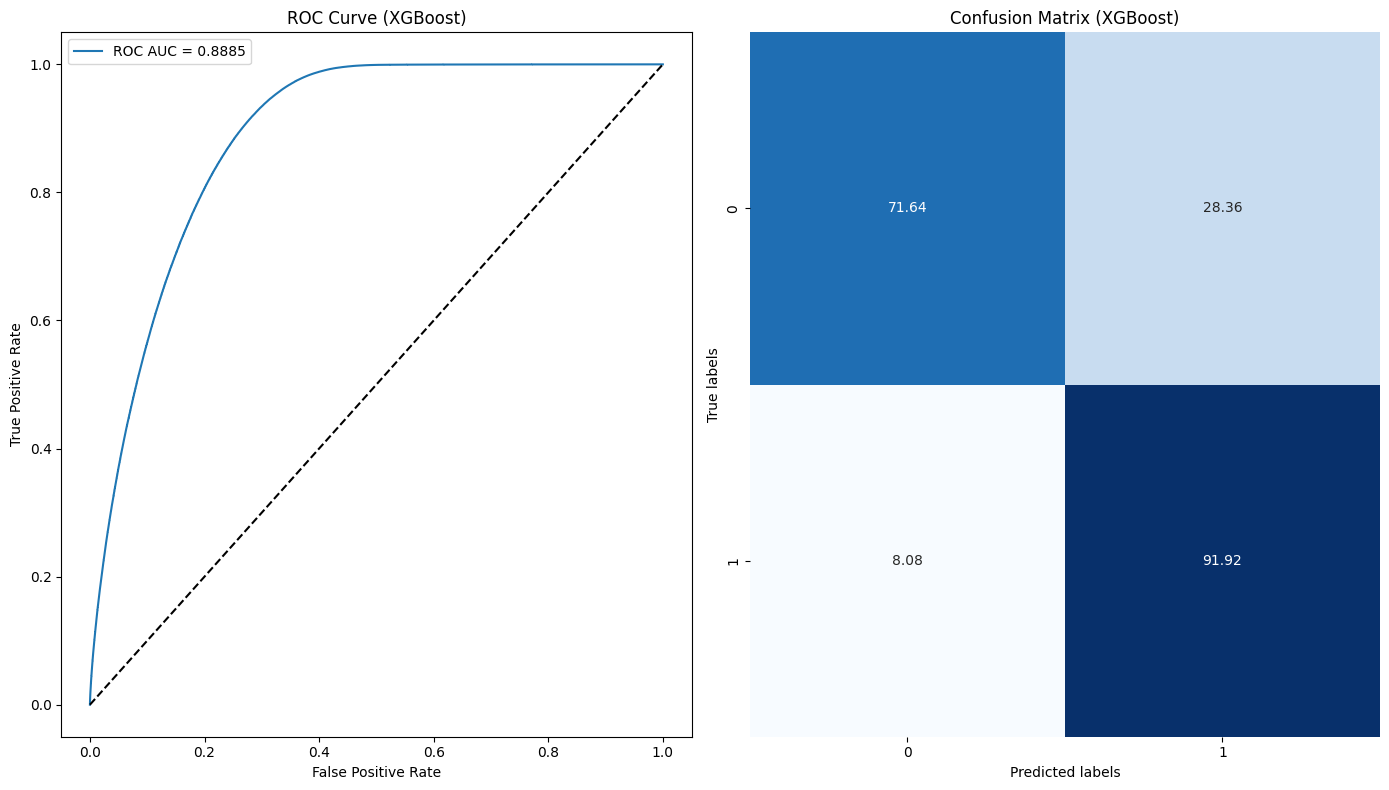

In [25]:
# Plot ROC curve
roc_auc_test_xgb = roc_auc_score(y_test, xgbc.predict_proba(X_test_trans)[:,1])
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb[:,1])

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

axes[0].plot(fpr_xgb, tpr_xgb, label=f'ROC AUC = {roc_auc_test_xgb:.4f}')
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve (XGBoost)')
axes[0].legend(loc='best')

# Confusion matrix
cm = confusion_matrix(y_test, xgbc.predict(X_test_trans))
cm_percentage = cm / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot confusion matrix
sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', cbar=False, ax=axes[1])
axes[1].set_xlabel('Predicted labels')
axes[1].set_ylabel('True labels')
axes[1].set_title('Confusion Matrix (XGBoost)')

plt.tight_layout()
plt.show()

## Catboost:

In [26]:
from catboost import CatBoostClassifier

#### Initialize the CatBoost classifier
cbc = CatBoostClassifier(random_state=512,
    objective="Logloss",  # Equivalent to "binary:logistic" in XGBoost
    eval_metric='AUC',  # Equivalent to 'auc' in XGBoost
    depth=8,  # Equivalent to max_depth
    min_data_in_leaf=13,  # Equivalent to min_child_weight
    learning_rate=0.2973547288176656,  # Equivalent to learning_rate
    n_estimators=914,  # Number of boosting rounds
    l2_leaf_reg=4.5257568564763595,  # Equivalent to reg_lambda
    bagging_temperature=0.0022240625943131627,  # Controls the amount of randomization in CatBoost (similar to colsample_bytree)
    early_stopping_rounds=10,  # Similar to early_stopping_rounds in XGBoost
    scale_pos_weight = ratio,
    silent=True
)

In [27]:
cbc.fit(X_train_trans,y_train, verbose = 50)
y_pred_cbc = cbc.predict_proba(X_test_trans)

print('ROC_AUC_Score cbc train: ',round(roc_auc_score(y_train,cbc.predict_proba(X_train_trans)[:,1]) * 100,2))
print('ROC_AUC_Score cbc test: ',round(roc_auc_score(y_test,cbc.predict_proba(X_test_trans)[:,1]) * 100,2))

0:	total: 2.02s	remaining: 30m 40s
50:	total: 1m 9s	remaining: 19m 32s
100:	total: 2m 17s	remaining: 18m 27s
150:	total: 3m 25s	remaining: 17m 18s
200:	total: 4m 33s	remaining: 16m 11s
250:	total: 5m 42s	remaining: 15m 4s
300:	total: 6m 52s	remaining: 14m
350:	total: 8m 2s	remaining: 12m 54s
400:	total: 9m 11s	remaining: 11m 46s
450:	total: 10m 21s	remaining: 10m 37s
500:	total: 11m 30s	remaining: 9m 28s
550:	total: 12m 38s	remaining: 8m 19s
600:	total: 13m 48s	remaining: 7m 11s
650:	total: 14m 56s	remaining: 6m 2s
700:	total: 16m 5s	remaining: 4m 53s
750:	total: 17m 16s	remaining: 3m 45s
800:	total: 18m 23s	remaining: 2m 35s
850:	total: 19m 33s	remaining: 1m 26s
900:	total: 20m 42s	remaining: 17.9s
913:	total: 21m	remaining: 0us
ROC_AUC_Score cbc train:  88.88
ROC_AUC_Score cbc test:  88.37


In [28]:
#### Get feature importances
feature_importances = cbc.get_feature_importance()

# Get feature names
feature_names = coltrans.get_feature_names_out()

# Create a DataFrame for the feature importances
feature_importance_cbc = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
})

# Sort the DataFrame by importance
feature_importance_cbc = feature_importance_cbc.sort_values(by='importance', ascending=False)

# Print the DataFrame
feature_importance_cbc

,feature,importance
17,standard_2__Previously_Insured_x_Vehicle_Damage,25.667555
7,minmax__Previously_Insured,16.246275
4,minmax__Age,7.667701
9,minmax__Vintage,6.583941
11,robust__Annual_Premium,5.875339
16,standard_2__Previously_Insured_x_Policy_Sales_...,4.868316
6,minmax__Region_Code,4.627530
18,standard_2__Previously_Insured_x_Annual_Premium,4.318250
19,standard_2__Previously_Insured_x_Vintage,4.309048
3,cat__Vehicle_Damage_Yes,2.805867


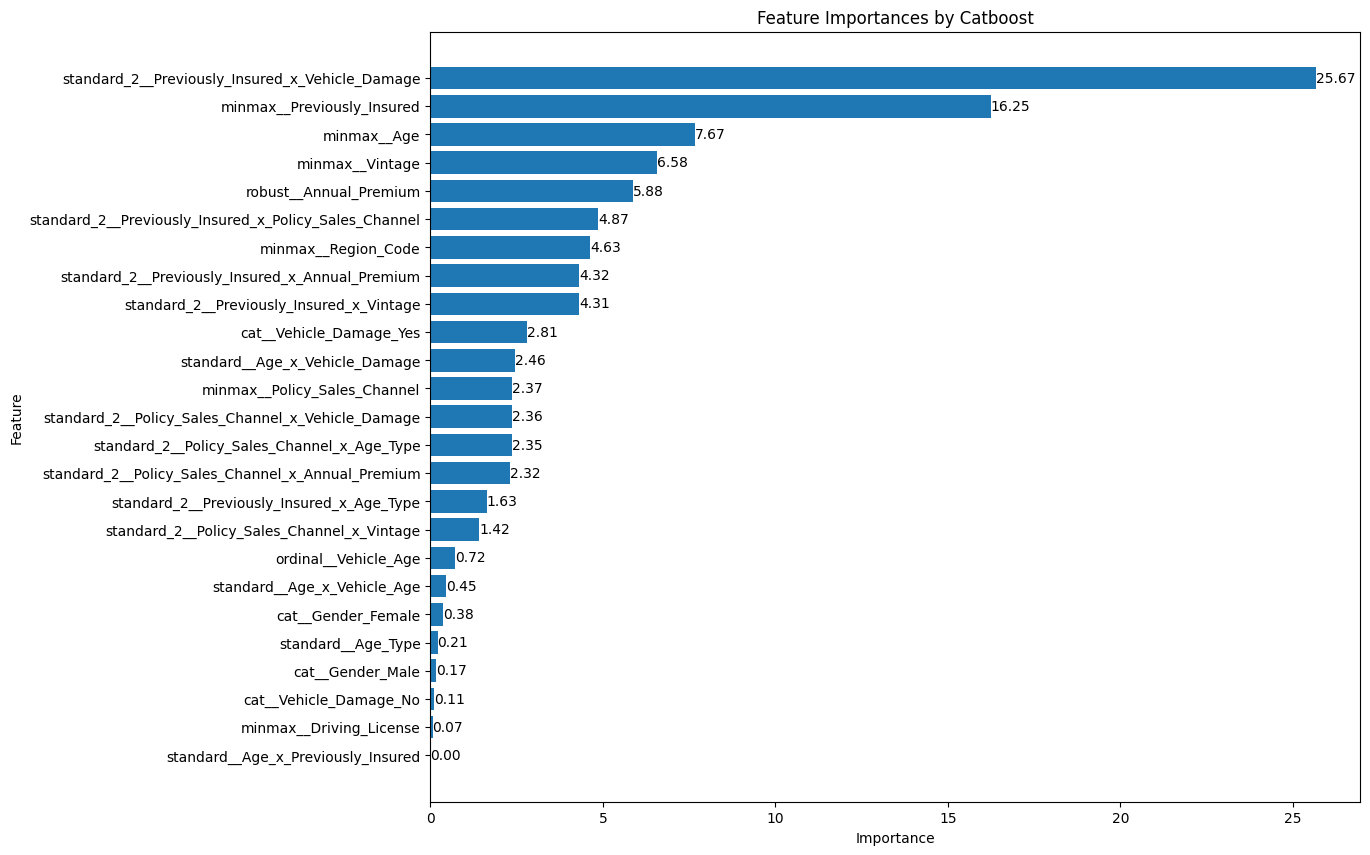

In [29]:
#### Assuming feature_importance_cbc is a DataFrame with columns 'feature' and 'importance'
plt.figure(figsize=(12, 10))
bars = plt.barh(feature_importance_cbc['feature'], feature_importance_cbc['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances by Catboost')
plt.gca().invert_yaxis()

### Add labels to the bars
plt.gca().bar_label(bars, fmt='%.2f')

plt.show()

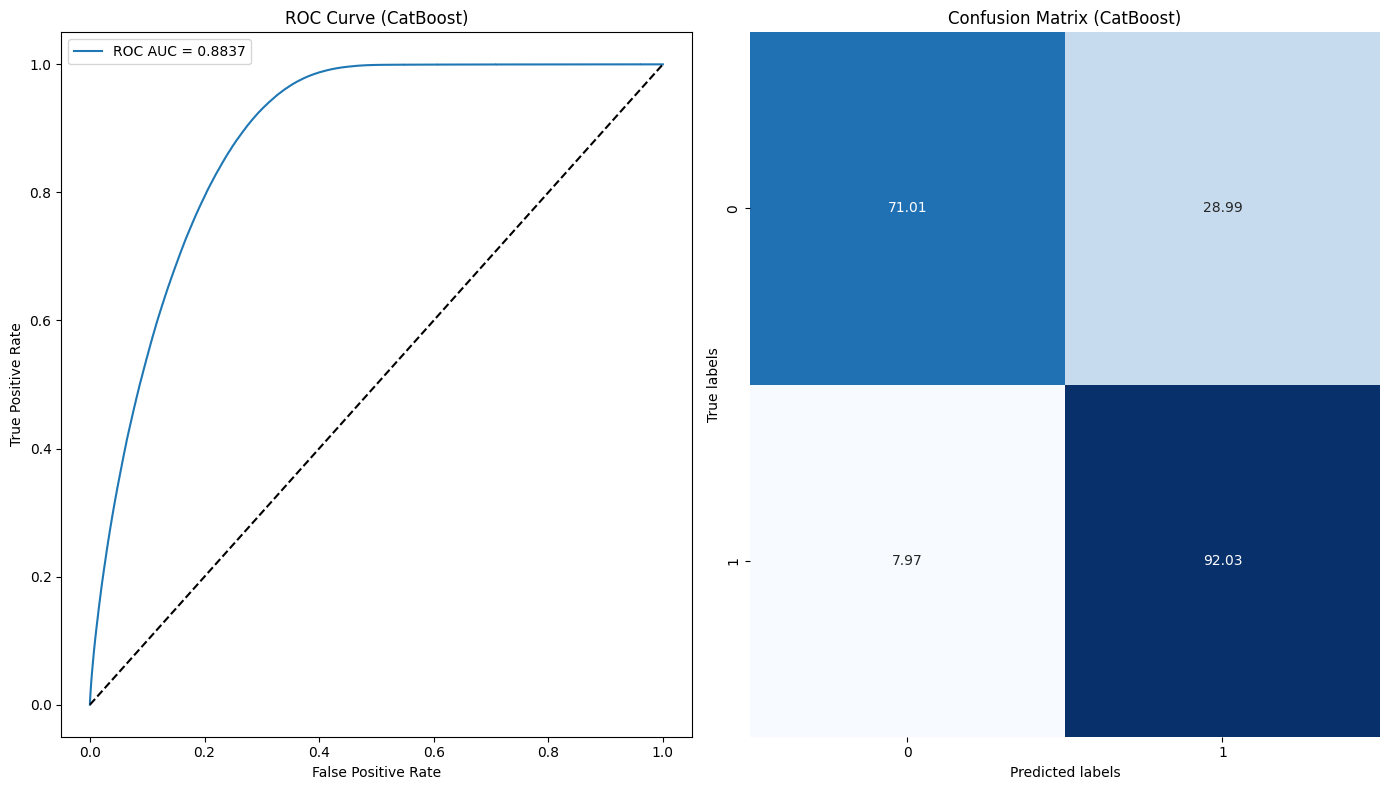

In [30]:
### Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

### Plot ROC curve
roc_auc_test_cbc = roc_auc_score(y_test, y_pred_cbc[:, 1])
fpr_cbc, tpr_cbc, _ = roc_curve(y_test, y_pred_cbc[:, 1])
axes[0].plot(fpr_cbc, tpr_cbc, label=f'ROC AUC = {roc_auc_test_cbc:.4f}')
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve (CatBoost)')
axes[0].legend(loc='best')

### Confusion matrix
cm_cbc = confusion_matrix(y_test, cbc.predict(X_test_trans))
cm_percentage_cbc = cm_cbc / cm_cbc.sum(axis=1)[:, np.newaxis] * 100

### Plot confusion matrix
sns.heatmap(cm_percentage_cbc, annot=True, fmt='.2f', cmap='Blues', cbar=False, ax=axes[1])
axes[1].set_xlabel('Predicted labels')
axes[1].set_ylabel('True labels')
axes[1].set_title('Confusion Matrix (CatBoost)')

plt.tight_layout()
plt.show()

## Light GBM:

In [31]:
import lightgbm as lgb

### Initialize the LightGBM classifier (parameter from reference)
lgbm = lgb.LGBMClassifier(
    random_state=512,
    objective='binary',
    n_estimators=2350,
    num_leaves=60,
    min_child_samples=20,
    colsample_bytree=0.3,
    subsample=0.6,
    learning_rate=0.2,
    max_depth=8,
    reg_alpha=6,
    reg_lambda=1.5,
    max_bin=300,
    min_data_in_bin=2,
    scale_pos_weight=ratio,
    verbose=-1  # Suppress output
)

lgbm.fit(X_train_trans,y_train, eval_metric='auc')
y_pred_lgbm = lgbm.predict_proba(X_test_trans)

print('ROC_AUC_Score LightGBM train: ',round(roc_auc_score(y_train,lgbm.predict_proba(X_train_trans)[:,1]) * 100,2))
print('ROC_AUC_Score LightGBM test: ',round(roc_auc_score(y_test,lgbm.predict_proba(X_test_trans)[:,1]) * 100,2))

ROC_AUC_Score LightGBM train:  89.79
ROC_AUC_Score LightGBM test:  88.59


In [32]:
# Get feature importances
feature_importances = lgbm.feature_importances_

# Get feature names
feature_names = coltrans.get_feature_names_out()

# Create a DataFrame for the feature importances
feature_importance_lgbm = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
})

# Sort the DataFrame by importance
feature_importance_lgbm = feature_importance_lgbm.sort_values(by='importance', ascending=False)
feature_importance_lgbm

,feature,importance
18,standard_2__Previously_Insured_x_Annual_Premium,27410
23,standard_2__Policy_Sales_Channel_x_Vintage,15563
6,minmax__Region_Code,13382
4,minmax__Age,10245
22,standard_2__Policy_Sales_Channel_x_Annual_Premium,10087
19,standard_2__Previously_Insured_x_Vintage,7623
24,standard_2__Policy_Sales_Channel_x_Age_Type,7183
16,standard_2__Previously_Insured_x_Policy_Sales_...,6154
9,minmax__Vintage,6059
21,standard_2__Policy_Sales_Channel_x_Vehicle_Damage,6041


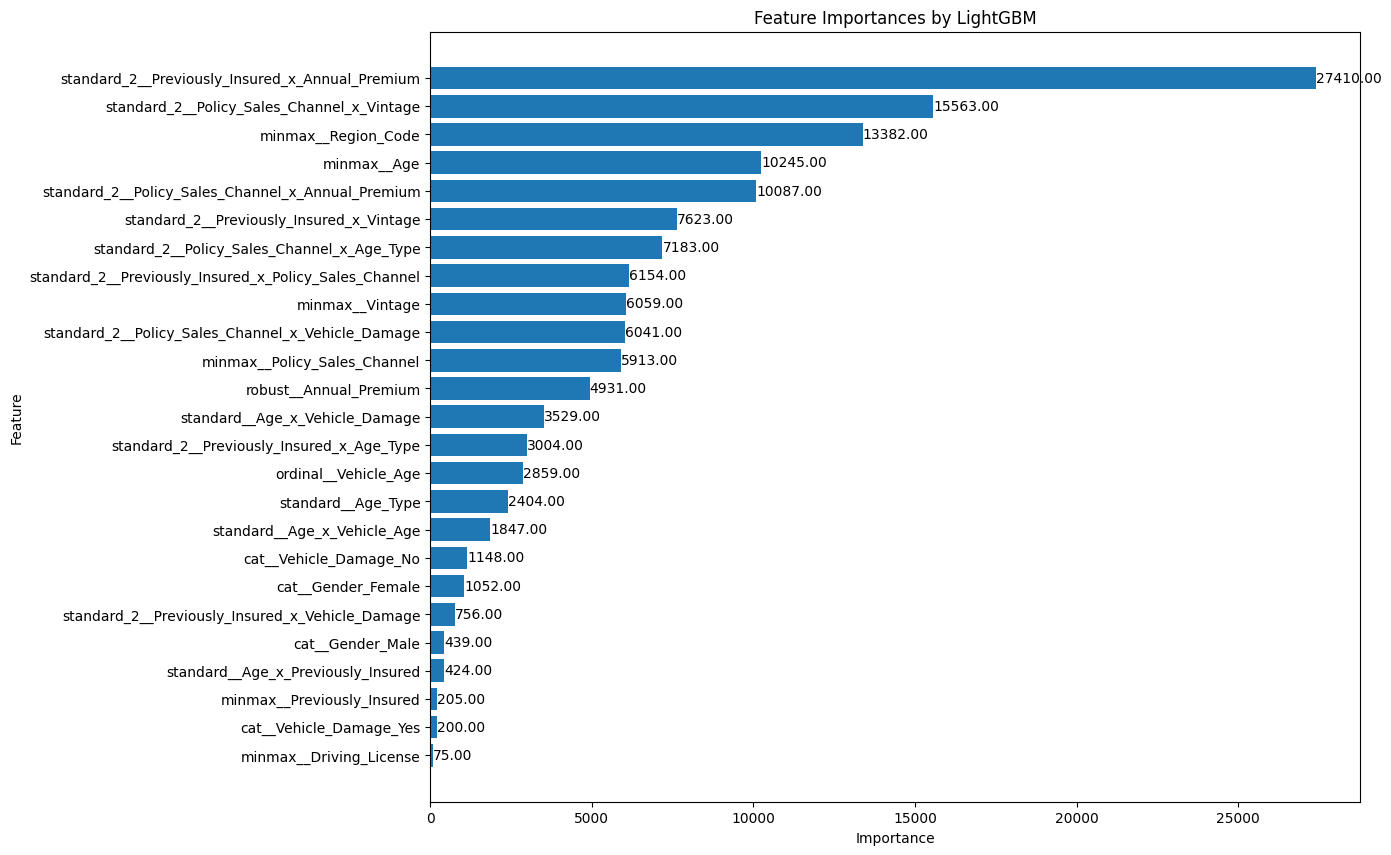

In [33]:
# Assuming feature_importance_cbc is a DataFrame with columns 'feature' and 'importance'
plt.figure(figsize=(12, 10))
bars = plt.barh(feature_importance_lgbm['feature'], feature_importance_lgbm['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances by LightGBM')
plt.gca().invert_yaxis()

# Add labels to the bars
plt.gca().bar_label(bars, fmt='%.2f')

plt.show()

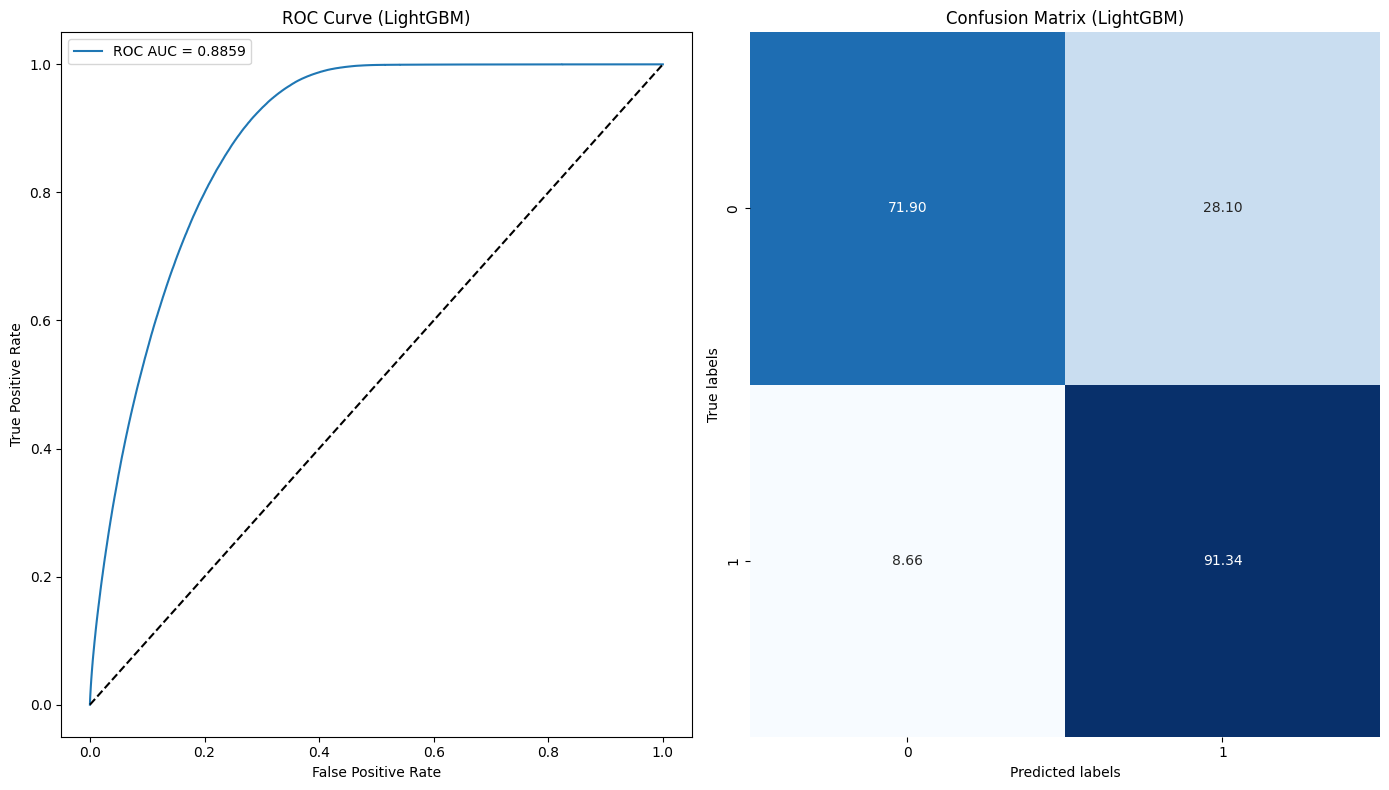

In [34]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# Plot ROC curve
roc_auc_test_lgbm = roc_auc_score(y_test, y_pred_lgbm[:, 1])
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_pred_lgbm[:, 1])
axes[0].plot(fpr_lgbm, tpr_lgbm, label=f'ROC AUC = {roc_auc_test_lgbm:.4f}')
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve (LightGBM)')
axes[0].legend(loc='best')

# Confusion matrix
cm_lgbm = confusion_matrix(y_test, lgbm.predict(X_test_trans))
cm_percentage_lgbm = cm_lgbm / cm_lgbm.sum(axis=1)[:, np.newaxis] * 100

# Plot confusion matrix
sns.heatmap(cm_percentage_lgbm, annot=True, fmt='.2f', cmap='Blues', cbar=False, ax=axes[1])
axes[1].set_xlabel('Predicted labels')
axes[1].set_ylabel('True labels')
axes[1].set_title('Confusion Matrix (LightGBM)')

plt.tight_layout()
plt.show()

## Compare Performance between 3 Models:

## Model Comparison: XGBoost, CatBoost, and LightGBM

This section compares **XGBoost**, **CatBoost**, and **LightGBM** based on feature importance, ROC AUC curves, and confusion matrices.

### Key Steps:
1. **Feature Importance**: 
   - Bar plots show which features most influence predictions for each model.

2. **ROC AUC Curves**: 
   - Higher AUC indicates better classification performance.

3. **Confusion Matrices**: 
   - Analyze True/False Positives and Negatives to assess precision and recall.

In [ ]:
# Set up the plotting space with a single row and three columns
fig, axes = plt.subplots(3, 1, figsize=(25, 45))

# Function to add importance score annotations
def add_annotations(ax, data):
    for p in ax.patches:
        ax.annotate(format(p.get_width(), '.3f'), 
                    (p.get_width(), p.get_y() + p.get_height() / 2.), 
                    ha = 'center', va = 'center', 
                    xytext = (10, 0), 
                    textcoords = 'offset points')

# Plot XGBoost feature importances
sns.barplot(ax=axes[0], x='importance', y='feature', data=feature_importance_xgb)
axes[0].set_title('XGBoost Feature Importances')
axes[0].set_xlabel('Importance')
axes[0].set_ylabel('Feature')
add_annotations(axes[0], feature_importance_xgb)

# Plot CatBoost feature importances
sns.barplot(ax=axes[1], x='importance', y='feature', data=feature_importance_cbc)
axes[1].set_title('CatBoost Feature Importances')
axes[1].set_xlabel('Importance')
axes[1].set_ylabel('Feature')
add_annotations(axes[1], feature_importance_cbc)

# Plot LightGBM feature importances
sns.barplot(ax=axes[2], x='importance', y='feature', data=feature_importance_lgbm)
axes[2].set_title('LightGBM Feature Importances')
axes[2].set_xlabel('Importance')
axes[2].set_ylabel('Feature')
add_annotations(axes[2], feature_importance_lgbm)

# Adjust layout
plt.tight_layout()
plt.show()

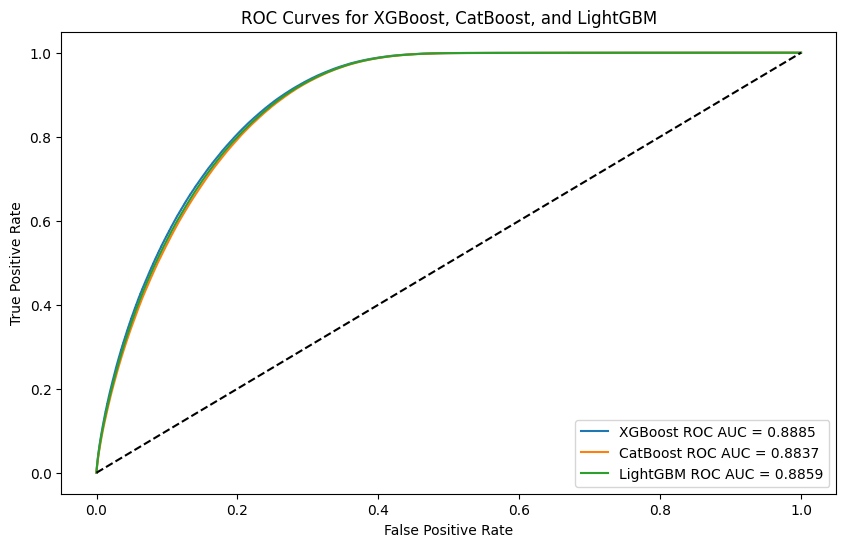

In [36]:
# Plot ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost ROC AUC = {roc_auc_test_xgb:.4f}')
plt.plot(fpr_cbc, tpr_cbc, label=f'CatBoost ROC AUC = {roc_auc_test_cbc:.4f}')
plt.plot(fpr_lgbm, tpr_lgbm, label=f'LightGBM ROC AUC = {roc_auc_test_lgbm:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for XGBoost, CatBoost, and LightGBM')
plt.legend(loc='best')
plt.show()

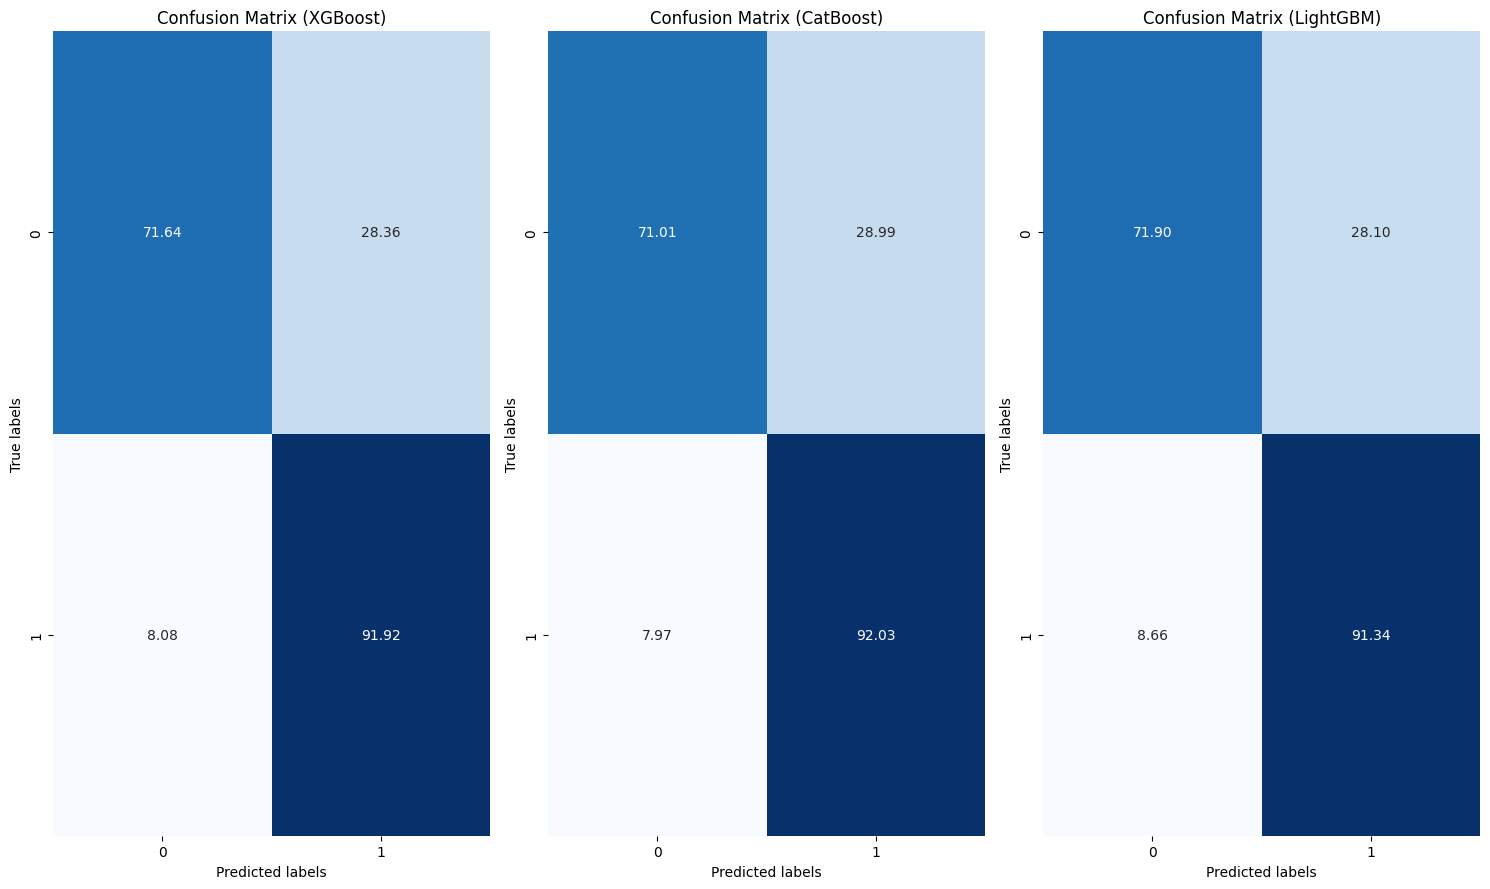

In [37]:
# Create subplots for confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 9))

# XGBoost Confusion Matrix
cm_xgb = confusion_matrix(y_test, xgbc.predict(X_test_trans))
cm_percentage_xgb = cm_xgb / cm_xgb.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_percentage_xgb, annot=True, fmt='.2f', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_xlabel('Predicted labels')
axes[0].set_ylabel('True labels')
axes[0].set_title('Confusion Matrix (XGBoost)')

# CatBoost Confusion Matrix
cm_cbc = confusion_matrix(y_test, cbc.predict(X_test_trans))
cm_percentage_cbc = cm_cbc / cm_cbc.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_percentage_cbc, annot=True, fmt='.2f', cmap='Blues', cbar=False, ax=axes[1])
axes[1].set_xlabel('Predicted labels')
axes[1].set_ylabel('True labels')
axes[1].set_title('Confusion Matrix (CatBoost)')

# LightGBM Confusion Matrix
cm_lgbm = confusion_matrix(y_test, lgbm.predict(X_test_trans))
cm_percentage_lgbm = cm_lgbm / cm_lgbm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_percentage_lgbm, annot=True, fmt='.2f', cmap='Blues', cbar=False, ax=axes[2])
axes[2].set_xlabel('Predicted labels')
axes[2].set_ylabel('True labels')
axes[2].set_title('Confusion Matrix (LightGBM)')

plt.tight_layout()
plt.show()

### Findings:
- **LightGBM**: 
  - Best performer with **training ROC AUC 90.35** and **test ROC AUC 88.67**.
  - Highest True Negative Rate and lowest False Positive Rate.
  
- **CatBoost**:
  - Strong with **training ROC AUC 89.74** and **test ROC AUC 88.37**.
  - Best True Positive Rate and lowest False Negative Rate.

- **XGBoost**:
  - Solid with **training ROC AUC 89.74** and **test ROC AUC 88.85**.
  - Slightly weaker confusion matrix metrics than others.

### Conclusion:
**LightGBM** offers the best overall performance, but **XGBoost** may still be preferred for other considerations.

## Prediction and Submission

Test data is preprocessed, predictions are made using the **XGBoost** model, and the results are saved as a CSV file for submission.

In [38]:
test_df

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,...,Age_x_Previously_Insured,Previously_Insured_x_Policy_Sales_Channel,Previously_Insured_x_Vehicle_Damage,Previously_Insured_x_Annual_Premium,Previously_Insured_x_Vintage,Previously_Insured_x_Age_Type,Policy_Sales_Channel_x_Vehicle_Damage,Policy_Sales_Channel_x_Annual_Premium,Policy_Sales_Channel_x_Vintage,Policy_Sales_Channel_x_Age_Type
id,,,,,,,,,,,,,,,,,,,,,
11504798,Female,20,1,47.0,0,< 1 Year,No,2630.0,160.0,228,...,0,8,2,3,55,0,5,52,945,8
11504799,Male,47,1,28.0,0,1-2 Year,Yes,37483.0,124.0,123,...,0,0,0,1211,230,1,0,23236,950,13
11504800,Male,47,1,43.0,0,1-2 Year,Yes,2630.0,26.0,271,...,0,1,0,3,392,1,1,9,598,1
11504801,Female,22,1,47.0,1,< 1 Year,No,24502.0,152.0,115,...,0,2,1,7102,325,2,2,7615,414,2
11504802,Male,51,1,19.0,0,1-2 Year,No,34115.0,124.0,148,...,0,0,2,14835,415,8,14,48134,797,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19174659,Male,57,1,28.0,0,1-2 Year,Yes,51661.0,124.0,109,...,0,0,0,8476,518,8,0,56038,989,16
19174660,Male,28,1,50.0,1,< 1 Year,No,25651.0,152.0,184,...,0,2,1,28152,463,2,2,36464,758,2
19174661,Male,47,1,33.0,1,1-2 Year,No,2630.0,138.0,63,...,2,145,1,18,115,7,147,11980,26725,301


In [39]:
test_df = test_df.drop(['age_bins','Response'],axis=1)            
test_df
test_trans = coltrans.transform(test_df)
pd.DataFrame(test_trans, columns = coltrans.get_feature_names_out())

,cat__Gender_Female,cat__Gender_Male,cat__Vehicle_Damage_No,cat__Vehicle_Damage_Yes,minmax__Age,minmax__Driving_License,minmax__Region_Code,minmax__Previously_Insured,minmax__Policy_Sales_Channel,minmax__Vintage,...,standard__Age_x_Previously_Insured,standard_2__Previously_Insured_x_Policy_Sales_Channel,standard_2__Previously_Insured_x_Vehicle_Damage,standard_2__Previously_Insured_x_Annual_Premium,standard_2__Previously_Insured_x_Vintage,standard_2__Previously_Insured_x_Age_Type,standard_2__Policy_Sales_Channel_x_Vehicle_Damage,standard_2__Policy_Sales_Channel_x_Annual_Premium,standard_2__Policy_Sales_Channel_x_Vintage,standard_2__Policy_Sales_Channel_x_Age_Type
0,1.0,0.0,1.0,0.0,0.000000,1.0,0.903846,0.0,0.981481,0.754325,...,-0.414247,-0.070340,1.945869,-0.929209,-1.285487,-1.081579,-0.218488,-0.655668,-0.182647,-0.318472
1,0.0,1.0,0.0,1.0,0.415385,1.0,0.538462,0.0,0.759259,0.391003,...,-0.414247,-0.483803,-0.892909,-0.861977,-0.207739,-0.802372,-0.477604,-0.351742,-0.180564,-0.223729
2,0.0,1.0,0.0,1.0,0.415385,1.0,0.826923,0.0,0.154321,0.903114,...,-0.414247,-0.432120,-0.892909,-0.929209,0.789947,-0.802372,-0.425781,-0.656232,-0.327178,-0.451111
3,1.0,0.0,1.0,0.0,0.030769,1.0,0.903846,1.0,0.932099,0.363322,...,-0.414247,-0.380437,0.526480,-0.534110,0.377324,-0.523165,-0.373957,-0.556523,-0.403817,-0.432163
4,0.0,1.0,1.0,0.0,0.476923,1.0,0.365385,0.0,0.759259,0.477509,...,-0.414247,-0.483803,1.945869,-0.103725,0.931594,1.152075,0.247922,-0.025347,-0.244291,-0.166884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7669861,0.0,1.0,0.0,1.0,0.569231,1.0,0.538462,0.0,0.759259,0.342561,...,-0.414247,-0.483803,-0.892909,-0.457639,1.565925,1.152075,-0.477604,0.078269,-0.164320,-0.166884
7669862,0.0,1.0,1.0,0.0,0.123077,1.0,0.961538,1.0,0.932099,0.602076,...,-0.414247,-0.380437,0.526480,0.637442,1.227204,-0.523165,-0.373957,-0.178333,-0.260535,-0.432163
7669863,0.0,1.0,1.0,0.0,0.415385,1.0,0.634615,1.0,0.845679,0.183391,...,1.300980,7.010220,0.526480,-0.928375,-0.915973,0.872868,7.140417,-0.499301,10.555128,5.233437
7669864,0.0,1.0,0.0,1.0,0.153846,1.0,0.538462,0.0,0.759259,0.377163,...,-0.414247,-0.483803,-0.892909,-0.606240,-0.103044,-0.243959,-0.477604,-0.575728,-0.175982,-0.091090


In [40]:
final_predictions = xgbc.predict_proba(test_trans)[:, 1]

submit = pd.DataFrame({
    'id': test.index,
    'Response': final_predictions
})
submit.to_csv('submission.csv',index=False)
print('DONE')
submit

DONE


,id,Response
0,11504798,0.040635
1,11504799,0.871455
2,11504800,0.685665
3,11504801,0.000582
4,11504802,0.419792
...,...,...
7669861,19174659,0.625036
7669862,19174660,0.001159
7669863,19174661,0.001304
7669864,19174662,0.913449
